In [1]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction
from qiskit.utils import QuantumInstance
from qiskit import IBMQ, BasicAer, Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms import VQE



def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

def get_qubit_op(coordinates):
    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0],coordinates[1],0]],
            ["H", [coordinates[2],coordinates[3],0]],
            ["H", [coordinates[4],coordinates[5],0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=1,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter,simulator='qasm', shots=1028):

    
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        quantum_instance = QuantumInstance(backend,shots=shots)
        optimizer = COBYLA(maxiter=400)
    elif simulator == 'exact':
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = COBYLA(maxiter=400)
    else:
        print('Error: simulator should be qasm or exact!')
 
    result = exact_solver(problem,converter)


    init_state = HartreeFock(num_orb, num_part, converter)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(op)
    min_eng = vqe_result.eigenvalue
    final_params = vqe_result.optimal_parameters 
    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    print('ground state energy: ',min_eng)
    
    return vqe_ground, min_eng

In [2]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst
m = 16 #times which we calculate the force

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli
#from hamiltonian import calc_ground_state, get_qubit_op
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit import IBMQ, BasicAer, Aer

import time #to see which part of code takes the longest


def get_psi_0(coordinates, simulator='qasm',shots=1028):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, simulator,shots=shots)
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_forces(coordinates, psi=None, simulator='qasm'):
    
    psi_0 = psi
    
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, simulator)
        
    if simulator == 'exact':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=1028)
    elif simulator == "exact":
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    forces = []
    vars = []
    #loop over particles
    
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
        Obs_var = Obs*Obs
        print("PRIMITIVE LIST")
        print(Obs_var.primitive.to_list())
        nuc = rep_eng_plus - rep_eng_minus
        #Obs_squared = Obs * Obs
       
        #get the expectation value <psi_0|O|psi_0>Ã‚Â¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        measurable_expression_var = StateFn(Obs_var, is_measurement=True).compose(psi_0)
        #measurable_expression_var =  StateFn(Obs_squared, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)
        expectation_var = PauliExpectation().convert(measurable_expression_var)
 
        #expectation_var = PauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation)
        sampler_var = CircuitSampler(q_instance).convert(expectation_var)
        #sampler_var = CircuitSampler(q_instance).convert(expectation) 

        f = sampler.eval().real + nuc
        ff = sampler_var.eval().real + 2*sampler.eval().real*nuc +nuc**2 +(sampler.eval().real)**2
        print(ff)
        #print(sampler_var.eval())
        #variance = sampler_var.eval().real - f^2
        forces.append(f*Ha*(1/(2*dR*angst)))
        vars.append(ff*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces,vars


def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, mode = 'full', shots = 1028):
    
    if simulator == 'exact':
            backend = Aer.get_backend('qasm_simulator') 
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == "qasm":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)   
    
    start = time.time()
    psi_0 = get_psi_0(coordinates, simulator = simulator, shots=shots)
    end = time.time()
    
    time_psi_0 = end - start

    forces = np.zeros(num_coord)
    force_ops = []
    force_op_coeffs = [] # array with dictionaries containing Pauli coefficients
    coordinates = coordinates.tolist()
    
    
    start = time.time()
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 
    for i in range(num_coord):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
        op =  -(qubit_op_plus - qubit_op_minus)
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        force_ops.append(op)
        force_op_coeffs.append(op_dict)
        
        if i == 0:  #we need two Pauli Ops to calculate the product and their support
            P1 = op
    
    
    if PauliSet == None:
        
        pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
        
            P_prod = P1@P1
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    end = time.time()
    
    time_pauli_ops = end - start
        

        # Now we calculate the expectation values of all the relevant PauliOps
    
    start = time.time()
    exp_dict = {} # dictionary with relevant expectation values
        
    for pauli_string in pauli_op_set:
            
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
            
        exp_dict[pauli_string] = E
                
    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
            forces[i] += coeff.real*exp_dict[pauli_op]
            
    end = time.time()   
    time_calc_exp = end - start
    
    
    start = time.time()
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        
    for i in range(num_coord):
        for j in range(i,num_coord):

            Pij = force_ops[i]@force_ops[j]
            Pij_list = Pij.primitive.to_list()

            #add product expectation <FiFj>
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
                    #subtract <Fi><Fj>
            COV[i,j] -= forces[i]*forces[j]

            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j]
    end = time.time()
    
    time_cov = end - start

    #print(f'Time to: Calculate Ground State - {round(time_psi_0,2)}s, Get Pauli Ops - {round(time_pauli_ops,2)}s, Calculate Pauli Expectation Values - {round(time_calc_exp,2)}s, Calculate Covariance - {round(time_cov,2)}s')
    print(COV)
    return forces*Ha*(1/(2*dR*angst)),COV*(Ha*(1/(2*dR*angst)))**2

In [3]:
#from Quantech.verlet_integrator import distance
#from force import calc_force_and_cov
import numpy as np
from tqdm import tqdm #to show progress


#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))


def main():
    #mass of particle1 (H)
    mass_0 = 1.67e-27
    #mass of particle2 (H)
    mass_1 = 1.67e-27
    #mass of particle3 (H)
    mass_2 = 1.67e-27
    #time step of integrator
    dt = 0.2*femto
    #initial velocity of atoms
    v_init_0 = np.array([0,0])
    v_init_1 = np.array([0,0])
    v_init_2 = np.array([0,0])

    v_init = np.concatenate((v_init_0,v_init_1,v_init_2),axis=None)

    #distances between atoms
    d = 0.8

    #initial positions of atoms, arrangement = equilateral triangle
    init_pos0 = np.array([0,0])
    init_pos1 = np.array([d,0])
    init_pos2 = np.array([d/2,np.sqrt(3)/2*d])
    init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)

    #integrator timesteps
    times = np.arange(0*femto, 20.0*femto, dt)
    #coordinate array
    coords = [init_pos]
    force = []
    distance01 = [d]
    distance02 = [d]
    distance12 = [d]
    #temperature in ?? 
    #k_B*T in Joule
    k_b = 1.38065e-23
    T = 420
    k_T = k_b*T
        #delta factor
    delta = 0.1*dt
    #hold v_next
    v_next = None
    
    simulator = 'qasm'

    for time in tqdm(times, desc='Progress: '):
        
        r = coords[-1]
        
        (forces,COV) = calc_force_and_cov(coords[-1],simulator = simulator, shots = 2000)
        
        if time == 0:

            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        else:

            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_next)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        print(d01)
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
        
    return (distance01,distance02,distance12,times)    

In [4]:
import matplotlib.pyplot as plt
(distance01,distance02,distance12,times) = main()

Progress:   0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


ground state energy:  (-3.213997900468431+0j)


Progress:   1%|          | 1/100 [01:03<1:44:38, 63.42s/it]

[[ 1.66723210e-05  3.27185888e-06 -1.66723210e-05  3.27185888e-06
   8.02886663e-15 -2.57031163e-05]
 [ 3.27185888e-06  6.42595013e-05 -3.27185891e-06  6.42595013e-05
   4.46053664e-15  5.98101312e-05]
 [-1.66723210e-05 -3.27185891e-06  1.66723210e-05 -3.27185887e-06
  -6.69659900e-15  2.57031163e-05]
 [ 3.27185888e-06  6.42595013e-05 -3.27185887e-06  6.42595013e-05
   8.01325032e-15  5.98101312e-05]
 [ 8.02886663e-15  4.46053664e-15 -6.69659900e-15  8.01325032e-15
  -1.30283775e-29  3.95536278e-15]
 [-2.57031163e-05  5.98101312e-05  2.57031163e-05  5.98101312e-05
   3.95536278e-15  1.05741666e-04]]
0.8051009100409231
ground state energy:  (-3.2045288307512356+0j)


Progress:   2%|▏         | 2/100 [01:59<1:36:58, 59.37s/it]

[[ 1.71543543e-05  3.53275586e-06 -1.71543543e-05  3.53275586e-06
  -3.97218683e-15 -2.62816650e-05]
 [ 3.53275586e-06  6.89416180e-05 -3.53275584e-06  6.89416180e-05
   2.23411960e-15  6.41168426e-05]
 [-1.71543543e-05 -3.53275584e-06  1.71543543e-05 -3.53275586e-06
   4.86036525e-15  2.62816650e-05]
 [ 3.53275586e-06  6.89416180e-05 -3.53275586e-06  6.89416180e-05
   4.45456565e-15  6.41168426e-05]
 [-3.97218683e-15  2.23411960e-15  4.86036525e-15  4.45456565e-15
  -1.77635684e-15 -9.17149816e-16]
 [-2.62816650e-05  6.41168426e-05  2.62816650e-05  6.41168426e-05
  -9.17149816e-16  1.11136348e-04]]
0.8149999523899109
ground state energy:  (-3.1851826108819266+0j)


Progress:   3%|▎         | 3/100 [02:57<1:34:50, 58.67s/it]

[[ 2.17996815e-05  7.70914089e-06 -2.17996815e-05  7.70914089e-06
  -9.27110561e-16 -3.01076601e-05]
 [ 7.70914089e-06  5.64243406e-05 -7.70914089e-06  5.64243406e-05
  -1.15681839e-14  4.40597136e-05]
 [-2.17996815e-05 -7.70914089e-06  2.17996815e-05 -7.70914089e-06
  -4.05157069e-16  3.01076601e-05]
 [ 7.70914089e-06  5.64243406e-05 -7.70914089e-06  5.64243406e-05
  -9.79182706e-15  4.40597136e-05]
 [-9.27110561e-16 -1.15681839e-14 -4.05157069e-16 -9.79182706e-15
   4.44089210e-16  1.37784245e-15]
 [-3.01076601e-05  4.40597136e-05  3.01076601e-05  4.40597136e-05
   1.37784245e-15  9.73173728e-05]]
0.8292212013896112
ground state energy:  (-3.1507627688454525+0j)


Progress:   4%|▍         | 4/100 [03:58<1:35:10, 59.48s/it]

[[ 1.33234749e-05 -2.97381605e-06 -1.33234749e-05 -2.97381605e-06
  -1.24468742e-14 -2.62551322e-05]
 [-2.97381605e-06  8.18852151e-05  2.97381603e-06  8.18852151e-05
  -2.22705307e-15  8.85473790e-05]
 [-1.33234749e-05  2.97381603e-06  1.33234749e-05  2.97381605e-06
   1.73318555e-14  2.62551322e-05]
 [-2.97381605e-06  8.18852151e-05  2.97381605e-06  8.18852151e-05
  -1.78296386e-15  8.85473790e-05]
 [-1.24468742e-14 -2.22705307e-15  1.73318555e-14 -1.78296386e-15
  -2.66453526e-15 -4.29249691e-16]
 [-2.62551322e-05  8.85473790e-05  2.62551322e-05  8.85473790e-05
  -4.29249691e-16  1.35918968e-04]]
0.8471403973528723
ground state energy:  (-3.1264788469955844+0j)


Progress:   5%|▌         | 5/100 [04:56<1:33:08, 58.83s/it]

[[ 6.03583141e-06  9.20306435e-07 -6.03583140e-06  9.20306435e-07
  -2.30982009e-14 -9.57571405e-06]
 [ 9.20306435e-07  2.23233747e-05 -9.20306429e-07  2.23233747e-05
   4.88184540e-15  2.11205134e-05]
 [-6.03583140e-06 -9.20306429e-07  6.03583140e-06 -9.20306436e-07
   2.04336656e-14  9.57571405e-06]
 [ 9.20306435e-07  2.23233747e-05 -9.20306436e-07  2.23233747e-05
   8.43455908e-15  2.11205134e-05]
 [-2.30982009e-14  4.88184540e-15  2.04336656e-14  8.43455908e-15
  -4.44089210e-16 -4.87848256e-15]
 [-9.57571405e-06  2.11205134e-05  9.57571405e-06  2.11205134e-05
  -4.87848256e-15  3.81771235e-05]]
0.8681056609508053
ground state energy:  (-3.084178777681337+0j)


Progress:   6%|▌         | 6/100 [05:54<1:31:57, 58.69s/it]

[[ 3.17918998e-05  2.38466209e-05 -3.17918998e-05  2.38466209e-05
  -2.19957587e-15 -3.11119751e-05]
 [ 2.38466209e-05  1.04031908e-04 -2.38466209e-05  1.04031908e-04
  -6.20446133e-15  6.43027448e-05]
 [-3.17918998e-05 -2.38466209e-05  3.17918998e-05 -2.38466209e-05
   2.64366508e-15  3.11119751e-05]
 [ 2.38466209e-05  1.04031908e-04 -2.38466209e-05  1.04031908e-04
  -5.31628291e-15  6.43027448e-05]
 [-2.19957587e-15 -6.20446133e-15  2.64366508e-15 -5.31628291e-15
   1.33226763e-15  3.97345713e-15]
 [-3.11119751e-05  6.43027448e-05  3.11119751e-05  6.43027448e-05
   3.97345713e-15  1.19607574e-04]]
0.8912579157632832
ground state energy:  (-3.0357020752036723+0j)


Progress:   7%|▋         | 7/100 [06:52<1:30:30, 58.39s/it]

[[ 7.42907181e-06  3.51077682e-06 -7.42907182e-06  3.51077682e-06
  -1.01830367e-14 -9.36624196e-06]
 [ 3.51077682e-06  1.14433738e-04 -3.51077682e-06  1.14433738e-04
  -4.42324806e-15  1.10230072e-04]
 [-7.42907182e-06 -3.51077682e-06  7.42907182e-06 -3.51077682e-06
   1.72884641e-14  9.36624197e-06]
 [ 3.51077682e-06  1.14433738e-04 -3.51077682e-06  1.14433738e-04
  -3.09098043e-15  1.10230072e-04]
 [-1.01830367e-14 -4.42324806e-15  1.72884641e-14 -3.09098043e-15
  -8.88178420e-16  2.62845796e-15]
 [-9.36624196e-06  1.10230072e-04  9.36624197e-06  1.10230072e-04
   2.62845796e-15  1.28379473e-04]]
0.9160710546415056
ground state energy:  (-2.98732617328392+0j)


Progress:   8%|▊         | 8/100 [07:49<1:28:51, 57.95s/it]

[[ 5.76039633e-06  1.92781952e-06 -5.76039632e-06  1.92781952e-06
  -1.76192439e-15 -8.07639813e-06]
 [ 1.92781952e-06  9.32155928e-05 -1.92781952e-06  9.32155928e-05
   2.31006427e-14  9.13607625e-05]
 [-5.76039632e-06 -1.92781952e-06  5.76039632e-06 -1.92781952e-06
   6.64690570e-15  8.07639813e-06]
 [ 1.92781952e-06  9.32155928e-05 -1.92781952e-06  9.32155928e-05
   2.31006427e-14  9.13607625e-05]
 [-1.76192439e-15  2.31006427e-14  6.64690570e-15  2.31006427e-14
   6.21724894e-15 -2.68153413e-15]
 [-8.07639813e-06  9.13607625e-05  8.07639813e-06  9.13607625e-05
  -2.68153413e-15  1.06905779e-04]]
0.9419169160678863
ground state energy:  (-2.9407853086821056+0j)


Progress:   9%|▉         | 9/100 [08:48<1:28:16, 58.20s/it]

[[ 5.02151621e-06 -5.12873086e-06 -5.02151623e-06 -5.12873087e-06
  -1.77588945e-14 -1.39415817e-05]
 [-5.12873086e-06  1.57038141e-04  5.12873088e-06  1.57038141e-04
   4.45533350e-16  1.68444094e-04]
 [-5.02151623e-06  5.12873088e-06  5.02151623e-06  5.12873087e-06
   1.82029837e-14  1.39415817e-05]
 [-5.12873087e-06  1.57038141e-04  5.12873087e-06  1.57038141e-04
  -1.33082349e-15  1.68444094e-04]
 [-1.77588945e-14  4.45533350e-16  1.82029837e-14 -1.33082349e-15
  -7.10542736e-15  6.65466970e-15]
 [-1.39415817e-05  1.68444094e-04  1.39415817e-05  1.68444094e-04
   6.65466970e-15  1.95356598e-04]]
0.9682145792227145
ground state energy:  (-2.911246009764224+0j)


Progress:  10%|█         | 10/100 [09:46<1:27:35, 58.39s/it]

[[ 1.27015072e-05  1.23088933e-06 -1.27015072e-05  1.23088933e-06
   1.77991373e-15 -2.08668684e-05]
 [ 1.23088933e-06  6.17683473e-05 -1.23088934e-06  6.17683473e-05
   1.33225045e-14  6.05520192e-05]
 [-1.27015072e-05 -1.23088934e-06  1.27015072e-05 -1.23088933e-06
   3.99324600e-15  2.08668684e-05]
 [ 1.23088933e-06  6.17683473e-05 -1.23088933e-06  6.17683473e-05
   1.50988613e-14  6.05520192e-05]
 [ 1.77991373e-15  1.33225045e-14  3.99324600e-15  1.50988613e-14
  -4.88498131e-15 -1.33863453e-15]
 [-2.08668684e-05  6.05520192e-05  2.08668684e-05  6.05520192e-05
  -1.33863453e-15  9.77953709e-05]]
0.9943681965468614
ground state energy:  (-2.8681642815741966+0j)


Progress:  11%|█         | 11/100 [10:47<1:27:32, 59.02s/it]

[[ 1.87953173e-05  1.25850621e-05 -1.87953173e-05  1.25850621e-05
  -5.33310787e-15 -1.99256501e-05]
 [ 1.25850621e-05  2.97549335e-04 -1.25850621e-05  2.97549335e-04
  -5.33092481e-15  2.80094455e-04]
 [-1.87953173e-05 -1.25850621e-05  1.87953173e-05 -1.25850621e-05
   4.48126557e-16  1.99256501e-05]
 [ 1.25850621e-05  2.97549335e-04 -1.25850621e-05  2.97549335e-04
  -5.77501402e-15  2.80094455e-04]
 [-5.33310787e-15 -5.33092481e-15  4.48126557e-16 -5.77501402e-15
  -4.44089210e-16 -4.87982786e-15]
 [-1.99256501e-05  2.80094455e-04  1.99256501e-05  2.80094455e-04
  -4.87982786e-15  3.18941546e-04]]
1.019886340258116
ground state energy:  (-2.8153947313647305+0j)


Progress:  12%|█▏        | 12/100 [11:49<1:27:50, 59.90s/it]

[[ 1.47645596e-05  7.63909478e-06 -1.47645596e-05  7.63909479e-06
  -8.44340551e-15 -1.79945104e-05]
 [ 7.63909478e-06  2.24559529e-04 -7.63909481e-06  2.24559529e-04
   1.32887115e-15  2.14417679e-04]
 [-1.47645596e-05 -7.63909481e-06  1.47645596e-05 -7.63909478e-06
   4.00251341e-15  1.79945104e-05]
 [ 7.63909479e-06  2.24559529e-04 -7.63909478e-06  2.24559529e-04
  -2.22384253e-15  2.14417679e-04]
 [-8.44340551e-15  1.32887115e-15  4.00251341e-15 -2.22384253e-15
  -1.33226763e-15 -1.32578405e-15]
 [-1.79945104e-05  2.14417679e-04  1.79945104e-05  2.14417679e-04
  -1.32578405e-15  2.48825661e-04]]
1.0444001773506484
ground state energy:  (-2.790878811954719+0j)


Progress:  13%|█▎        | 13/100 [12:49<1:27:11, 60.13s/it]

[[ 2.12436599e-05 -1.61610060e-05 -2.12436599e-05 -1.61610060e-05
  -7.15465752e-15 -5.33659572e-05]
 [-1.61610060e-05  3.27655085e-04  1.61610060e-05  3.27655085e-04
   7.92907643e-15  3.60397709e-04]
 [-2.12436599e-05  1.61610060e-05  2.12436599e-05  1.61610060e-05
   1.11514604e-14  5.33659572e-05]
 [-1.61610060e-05  3.27655085e-04  1.61610060e-05  3.27655085e-04
   3.48818433e-15  3.60397709e-04]
 [-7.15465752e-15  7.92907643e-15  1.11514604e-14  3.48818433e-15
  -1.77635684e-15  2.24065874e-15]
 [-5.33659572e-05  3.60397709e-04  5.33659572e-05  3.60397709e-04
   2.24065874e-15  4.58364293e-04]]
1.0675486036293615
ground state energy:  (-2.730625513179081+0j)


Progress:  14%|█▍        | 14/100 [13:50<1:26:20, 60.24s/it]

[[ 5.87722199e-05 -6.76319093e-06 -5.87722198e-05 -6.76319092e-06
  -8.92196075e-15 -1.09217539e-04]
 [-6.76319093e-06  6.95880847e-04  6.76319093e-06  6.95880847e-04
   8.75644512e-15  7.17228798e-04]
 [-5.87722198e-05  6.76319093e-06  5.87722198e-05  6.76319092e-06
   1.02542284e-14  1.09217539e-04]
 [-6.76319092e-06  6.95880847e-04  6.76319092e-06  6.95880847e-04
   2.53919618e-15  7.17228797e-04]
 [-8.92196075e-15  8.75644512e-15  1.02542284e-14  2.53919618e-15
   3.10862447e-15  1.23770706e-14]
 [-1.09217539e-04  7.17228798e-04  1.09217539e-04  7.17228797e-04
   1.23770706e-14  9.17316926e-04]]
1.088974872113521
ground state energy:  (-2.7184755332961683+0j)


Progress:  15%|█▌        | 15/100 [14:51<1:25:46, 60.55s/it]

[[ 2.90631814e-05 -2.47976916e-05 -2.90631814e-05 -2.47976916e-05
   6.71847898e-15 -7.56744779e-05]
 [-2.47976916e-05  6.37069819e-04  2.47976916e-05  6.37069819e-04
  -7.90817935e-15  6.89037369e-04]
 [-2.90631814e-05  2.47976916e-05  2.90631814e-05  2.47976916e-05
  -1.24916387e-14  7.56744779e-05]
 [-2.47976916e-05  6.37069819e-04  2.47976916e-05  6.37069819e-04
  -4.79955489e-15  6.89037369e-04]
 [ 6.71847898e-15 -7.90817935e-15 -1.24916387e-14 -4.79955489e-15
   2.66453526e-15 -8.00646172e-15]
 [-7.56744779e-05  6.89037369e-04  7.56744779e-05  6.89037369e-04
  -8.00646172e-15  8.30191440e-04]]
1.1086208274821878
ground state energy:  (-2.6824396603026726+0j)


Progress:  16%|█▌        | 16/100 [15:49<1:23:22, 59.56s/it]

[[ 4.38286631e-06 -6.95603635e-07 -4.38286630e-06 -6.95603624e-07
   1.14793528e-14 -8.33088891e-06]
 [-6.95603635e-07  9.62479219e-05  6.95603630e-07  9.62479219e-05
   6.17581957e-15  9.87452970e-05]
 [-4.38286630e-06  6.95603630e-07  4.38286630e-06  6.95603631e-07
  -7.92663908e-15  8.33088891e-06]
 [-6.95603624e-07  9.62479219e-05  6.95603631e-07  9.62479219e-05
   5.28764115e-15  9.87452970e-05]
 [ 1.14793528e-14  6.17581957e-15 -7.92663908e-15  5.28764115e-15
   4.44089210e-16 -3.69566505e-16]
 [-8.33088891e-06  9.87452970e-05  8.33088891e-06  9.87452970e-05
  -3.69566505e-16  1.14561830e-04]]
1.1262884963964326
ground state energy:  (-2.6592395719038158+0j)


Progress:  17%|█▋        | 17/100 [16:49<1:22:49, 59.87s/it]

[[ 3.11098720e-05 -1.96549283e-05 -3.11098720e-05 -1.96549283e-05
  -1.25995900e-14 -7.39394267e-05]
 [-1.96549283e-05  8.99414998e-04  1.96549284e-05  8.99414998e-04
   4.90416483e-15  9.45446294e-04]
 [-3.11098720e-05  1.96549284e-05  3.11098720e-05  1.96549283e-05
   1.03791440e-14  7.39394267e-05]
 [-1.96549283e-05  8.99414998e-04  1.96549283e-05  8.99414997e-04
   1.91835202e-17  9.45446293e-04]
 [-1.25995900e-14  4.90416483e-15  1.03791440e-14  1.91835202e-17
  -4.44089210e-15  9.85186602e-15]
 [-7.39394267e-05  9.45446294e-04  7.39394267e-05  9.45446293e-04
   9.85186602e-15  1.08636100e-03]]
1.141944971807248
ground state energy:  (-2.6207826456707304+0j)


Progress:  18%|█▊        | 18/100 [17:49<1:21:55, 59.94s/it]

[[ 3.86335907e-05 -7.72601420e-05 -3.86335907e-05 -7.72601419e-05
  -5.58379489e-15 -1.45456391e-04]
 [-7.72601420e-05  1.48130185e-03  7.72601419e-05  1.48130185e-03
  -1.26119113e-14  1.63458066e-03]
 [-3.86335907e-05  7.72601419e-05  3.86335907e-05  7.72601419e-05
   1.58699200e-15  1.45456391e-04]
 [-7.72601419e-05  1.48130185e-03  7.72601419e-05  1.48130185e-03
  -9.28124221e-15  1.63458066e-03]
 [-5.58379489e-15 -1.26119113e-14  1.58699200e-15 -9.28124221e-15
   8.88178420e-16  6.25277443e-15]
 [-1.45456391e-04  1.63458066e-03  1.45456391e-04  1.63458066e-03
   6.25277443e-15  1.90846579e-03]]
1.1555374334411657
ground state energy:  (-2.6222846120498446+0j)


Progress:  19%|█▉        | 19/100 [18:49<1:20:47, 59.85s/it]

[[ 1.83887145e-05  2.11712016e-06 -1.83887145e-05  2.11712016e-06
  -2.93945552e-15 -2.97878301e-05]
 [ 2.11712016e-06  3.64456483e-04 -2.11712014e-06  3.64456483e-04
  -1.29157657e-14  3.65321324e-04]
 [-1.83887145e-05 -2.11712014e-06  1.83887145e-05 -2.11712016e-06
   4.93785696e-15  2.97878301e-05]
 [ 2.11712016e-06  3.64456483e-04 -2.11712016e-06  3.64456483e-04
  -1.69125686e-14  3.65321324e-04]
 [-2.93945552e-15 -1.29157657e-14  4.93785696e-15 -1.69125686e-14
  -2.22044605e-16  4.98447607e-16]
 [-2.97878301e-05  3.65321324e-04  2.97878301e-05  3.65321324e-04
   4.98447607e-16  4.21600776e-04]]
1.166899044151905
ground state energy:  (-2.6089394731130957+0j)


Progress:  20%|██        | 20/100 [19:45<1:18:30, 58.88s/it]

[[ 2.34817337e-05  5.55621381e-06 -2.34817337e-05  5.55621380e-06
  -1.45023712e-15 -3.52255238e-05]
 [ 5.55621381e-06  3.51805030e-04 -5.55621382e-06  3.51805030e-04
   9.69060202e-15  3.46147138e-04]
 [-2.34817337e-05 -5.55621382e-06  2.34817337e-05 -5.55621380e-06
   8.55566448e-15  3.52255238e-05]
 [ 5.55621380e-06  3.51805030e-04 -5.55621380e-06  3.51805030e-04
   1.36874049e-14  3.46147138e-04]
 [-1.45023712e-15  9.69060202e-15  8.55566448e-15  1.36874049e-14
  -3.55271368e-15  1.16711221e-14]
 [-3.52255238e-05  3.46147138e-04  3.52255238e-05  3.46147138e-04
   1.16711221e-14  4.11364138e-04]]
1.1760201789220246
ground state energy:  (-2.577753783772516+0j)


Progress:  21%|██        | 21/100 [25:33<3:11:25, 145.38s/it]

[[ 3.80891448e-05  3.06138764e-05 -3.80891448e-05  3.06138764e-05
   1.97373930e-14 -3.50572464e-05]
 [ 3.06138764e-05  1.78622916e-03 -3.06138764e-05  1.78622916e-03
  -1.66880454e-14  1.75361308e-03]
 [-3.80891448e-05 -3.06138764e-05  3.80891448e-05 -3.06138764e-05
  -1.66287685e-14  3.50572464e-05]
 [ 3.06138764e-05  1.78622916e-03 -3.06138764e-05  1.78622915e-03
  -1.86864469e-14  1.75361308e-03]
 [ 1.97373930e-14 -1.66880454e-14 -1.66287685e-14 -1.86864469e-14
  -7.10542736e-15 -1.60845458e-14]
 [-3.50572464e-05  1.75361308e-03  3.50572464e-05  1.75361308e-03
  -1.60845458e-14  1.83446082e-03]]
1.1831455533724358
ground state energy:  (-2.5858620199333444+0j)


Progress:  22%|██▏       | 22/100 [27:27<2:57:02, 136.19s/it]

[[ 1.73801926e-05  1.51967949e-05 -1.73801926e-05  1.51967949e-05
   1.97599275e-15 -1.48982166e-05]
 [ 1.51967949e-05  3.72237429e-04 -1.51967949e-05  3.72237429e-04
   1.30893150e-14  3.49955092e-04]
 [-1.73801926e-05 -1.51967949e-05  1.73801926e-05 -1.51967949e-05
   4.01921158e-15  1.48982166e-05]
 [ 1.51967949e-05  3.72237429e-04 -1.51967949e-05  3.72237429e-04
   1.17570473e-14  3.49955092e-04]
 [ 1.97599275e-15  1.30893150e-14  4.01921158e-15  1.17570473e-14
  -8.65973959e-15  8.90928484e-15]
 [-1.48982166e-05  3.49955092e-04  1.48982166e-05  3.49955092e-04
   8.90928484e-15  3.79831364e-04]]
1.1879246593915775
ground state energy:  (-2.5719627901289672+0j)


Progress:  23%|██▎       | 23/100 [47:51<9:53:43, 462.65s/it]

[[ 2.67113044e-05  2.16109644e-05 -2.67113044e-05  2.16109644e-05
   2.67593534e-15 -2.46370144e-05]
 [ 2.16109644e-05  7.95645560e-04 -2.16109643e-05  7.95645560e-04
  -8.65271020e-15  7.67351771e-04]
 [-2.67113044e-05 -2.16109643e-05  2.67113044e-05 -2.16109644e-05
  -3.34206915e-15  2.46370144e-05]
 [ 2.16109644e-05  7.95645560e-04 -2.16109644e-05  7.95645560e-04
  -1.68683606e-14  7.67351771e-04]
 [ 2.67593534e-15 -8.65271020e-15 -3.34206915e-15 -1.68683606e-14
   1.11022302e-15  5.34424389e-16]
 [-2.46370144e-05  7.67351771e-04  2.46370144e-05  7.67351771e-04
   5.34424389e-16  8.19243363e-04]]
1.1905216969452768
ground state energy:  (-2.5641403653741097+0j)


Progress:  24%|██▍       | 24/100 [1:28:54<22:25:58, 1062.62s/it]

[[ 2.87025630e-05 -4.62420473e-05 -2.87025630e-05 -4.62420473e-05
  -1.26226185e-14 -9.66391280e-05]
 [-4.62420473e-05  1.08443137e-03  4.62420473e-05  1.08443137e-03
   1.44918721e-14  1.17751406e-03]
 [-2.87025630e-05  4.62420473e-05  2.87025630e-05  4.62420473e-05
   1.10683062e-14  9.66391280e-05]
 [-4.62420473e-05  1.08443137e-03  4.62420473e-05  1.08443137e-03
   1.33816490e-14  1.17751406e-03]
 [-1.26226185e-14  1.44918721e-14  1.10683062e-14  1.33816490e-14
   2.22044605e-15  1.94169997e-14]
 [-9.66391280e-05  1.17751406e-03  9.66391280e-05  1.17751406e-03
   1.94169997e-14  1.35923263e-03]]
1.1910690268665096
ground state energy:  (-2.572571159355171+0j)


Progress:  25%|██▌       | 25/100 [1:31:15<16:22:47, 786.24s/it] 

[[ 2.81650165e-05  1.84826135e-05 -2.81650165e-05  1.84826135e-05
  -1.72623667e-15 -3.01292095e-05]
 [ 1.84826135e-05  7.51463436e-04 -1.84826134e-05  7.51463435e-04
  -5.00001722e-15  7.27975817e-04]
 [-2.81650165e-05 -1.84826134e-05  2.81650165e-05 -1.84826134e-05
   1.71924431e-16  3.01292095e-05]
 [ 1.84826135e-05  7.51463435e-04 -1.84826134e-05  7.51463435e-04
  -7.22046326e-15  7.27975817e-04]
 [-1.72623667e-15 -5.00001722e-15  1.71924431e-16 -7.22046326e-15
  -4.66293670e-15 -8.23095806e-16]
 [-3.01292095e-05  7.27975817e-04  3.01292095e-05  7.27975817e-04
  -8.23095806e-16  7.88490170e-04]]
1.18958977721434
ground state energy:  (-2.5799600553840873+0j)


Progress:  26%|██▌       | 26/100 [1:32:15<11:40:56, 568.32s/it]

[[ 2.26381652e-05  1.01494780e-05 -2.26381652e-05  1.01494780e-05
  -5.82666514e-15 -2.90775920e-05]
 [ 1.01494780e-05  1.28177079e-04 -1.01494780e-05  1.28177079e-04
  -6.99294171e-16  1.11979618e-04]
 [-2.26381652e-05 -1.01494780e-05  2.26381652e-05 -1.01494780e-05
  -6.12628402e-16  2.90775920e-05]
 [ 1.01494780e-05  1.28177079e-04 -1.01494780e-05  1.28177079e-04
  -1.14338338e-15  1.11979618e-04]
 [-5.82666514e-15 -6.99294171e-16 -6.12628402e-16 -1.14338338e-15
  -4.21884749e-15 -1.93890010e-15]
 [-2.90775920e-05  1.11979618e-04  2.90775920e-05  1.11979618e-04
  -1.93890010e-15  1.63770552e-04]]
1.1859924180832802
ground state energy:  (-2.5784597242478413+0j)


Progress:  27%|██▋       | 27/100 [1:33:16<8:26:08, 416.00s/it] 

[[ 2.47422910e-05  1.22234809e-05 -2.47422910e-05  1.22234809e-05
   6.64783505e-15 -3.06529694e-05]
 [ 1.22234809e-05  1.50991197e-04 -1.22234809e-05  1.50991196e-04
   1.11825842e-14  1.31361170e-04]
 [-2.47422910e-05 -1.22234809e-05  2.47422910e-05 -1.22234809e-05
   6.79636910e-16  3.06529694e-05]
 [ 1.22234809e-05  1.50991196e-04 -1.22234809e-05  1.50991196e-04
   2.74488922e-15  1.31361170e-04]
 [ 6.64783505e-15  1.11825842e-14  6.79636910e-16  2.74488922e-15
   4.44089210e-16  7.10308931e-16]
 [-3.06529694e-05  1.31361170e-04  3.06529694e-05  1.31361170e-04
   7.10308931e-16  1.86050235e-04]]
1.1803994800896045
ground state energy:  (-2.592146949678051+0j)


Progress:  28%|██▊       | 28/100 [1:34:15<6:10:48, 309.00s/it]

[[ 3.34521304e-05  2.81047422e-05 -3.34521304e-05  2.81047422e-05
   1.05134549e-14 -2.97139530e-05]
 [ 2.81047422e-05  4.86130808e-04 -2.81047422e-05  4.86130808e-04
  -1.63768756e-14  4.42865352e-04]
 [-3.34521304e-05 -2.81047422e-05  3.34521304e-05 -2.81047422e-05
  -7.40483047e-15  2.97139530e-05]
 [ 2.81047422e-05  4.86130808e-04 -2.81047422e-05  4.86130808e-04
  -1.83752771e-14  4.42865352e-04]
 [ 1.05134549e-14 -1.63768756e-14 -7.40483047e-15 -1.83752771e-14
  -2.66453526e-15 -1.17442940e-14]
 [-2.97139530e-05  4.42865352e-04  2.97139530e-05  4.42865352e-04
  -1.17442940e-14  4.99598568e-04]]
1.173163064237319
ground state energy:  (-2.5651107539704214+0j)


Progress:  29%|██▉       | 29/100 [1:35:11<4:35:49, 233.10s/it]

[[ 5.35076507e-05  1.11387680e-04 -5.35076507e-05  1.11387680e-04
   1.14097100e-15  1.97528047e-05]
 [ 1.11387680e-04  1.75905913e-03 -1.11387680e-04  1.75905913e-03
  -4.98570796e-14  1.58577278e-03]
 [-5.35076507e-05 -1.11387680e-04  5.35076507e-05 -1.11387680e-04
  -2.25119403e-15 -1.97528046e-05]
 [ 1.11387680e-04  1.75905913e-03 -1.11387680e-04  1.75905913e-03
  -3.60903141e-14  1.58577278e-03]
 [ 1.14097100e-15 -4.98570796e-14 -2.25119403e-15 -3.60903141e-14
   5.77315973e-15 -2.48167667e-14]
 [ 1.97528047e-05  1.58577278e-03 -1.97528046e-05  1.58577278e-03
  -2.48167667e-14  1.56962684e-03]]
1.164970362204062
ground state energy:  (-2.598002538146546+0j)


Progress:  30%|███       | 30/100 [1:36:15<3:32:51, 182.44s/it]

[[ 4.97278766e-05 -4.92359777e-05 -4.97278766e-05 -4.92359777e-05
   2.73268615e-15 -1.36352495e-04]
 [-4.92359777e-05  1.14020843e-03  4.92359777e-05  1.14020843e-03
   1.78244838e-14  1.24051378e-03]
 [-4.97278766e-05  4.92359777e-05  4.97278766e-05  4.92359777e-05
  -6.28539983e-15  1.36352495e-04]
 [-4.92359777e-05  1.14020843e-03  4.92359777e-05  1.14020843e-03
   1.47158593e-14  1.24051378e-03]
 [ 2.73268615e-15  1.78244838e-14 -6.28539983e-15  1.47158593e-14
  -3.77475828e-15  2.69055190e-14]
 [-1.36352495e-04  1.24051378e-03  1.36352495e-04  1.24051378e-03
   2.69055190e-14  1.49362442e-03]]
1.155993940736114
ground state energy:  (-2.628347370087737+0j)


Progress:  31%|███       | 31/100 [1:37:12<2:46:30, 144.79s/it]

[[ 1.14660285e-05  9.52198619e-06 -1.14660285e-05  9.52198621e-06
   1.27582005e-15 -1.02893405e-05]
 [ 9.52198619e-06  2.53081347e-04 -9.52198620e-06  2.53081346e-04
  -6.24824299e-15  2.39616800e-04]
 [-1.14660285e-05 -9.52198620e-06  1.14660285e-05 -9.52198620e-06
  -8.38124741e-15  1.02893405e-05]
 [ 9.52198621e-06  2.53081346e-04 -9.52198620e-06  2.53081346e-04
  -2.91757391e-15  2.39616800e-04]
 [ 1.27582005e-15 -6.24824299e-15 -8.38124741e-15 -2.91757391e-15
   4.44089210e-16  6.68045588e-17]
 [-1.02893405e-05  2.39616800e-04  1.02893405e-05  2.39616800e-04
   6.68045588e-17  2.60420598e-04]]
1.144974270084963
ground state energy:  (-2.6426043009953064+0j)


Progress:  32%|███▏      | 32/100 [1:38:09<2:14:18, 118.51s/it]

[[ 1.86647361e-05  7.39803528e-06 -1.86647361e-05  7.39803528e-06
  -3.19275264e-15 -2.49405615e-05]
 [ 7.39803528e-06  3.21825604e-04 -7.39803528e-06  3.21825604e-04
  -4.13191351e-15  3.12743024e-04]
 [-1.86647361e-05 -7.39803528e-06  1.86647361e-05 -7.39803527e-06
   8.29977855e-15  2.49405615e-05]
 [ 7.39803528e-06  3.21825604e-04 -7.39803527e-06  3.21825604e-04
  -7.24053798e-15  3.12743024e-04]
 [-3.19275264e-15 -4.13191351e-15  8.29977855e-15 -7.24053798e-15
   3.10862447e-15 -3.70464541e-15]
 [-2.49405615e-05  3.12743024e-04  2.49405615e-05  3.12743024e-04
  -3.70464541e-15  3.59735325e-04]]
1.1322296653961468
ground state energy:  (-2.6322533498688725+0j)


Progress:  33%|███▎      | 33/100 [1:39:07<1:52:05, 100.38s/it]

[[ 8.74707725e-06  2.12161241e-05 -8.74707726e-06  2.12161241e-05
   1.77949506e-15  6.31095693e-06]
 [ 2.12161241e-05  5.23912020e-04 -2.12161241e-05  5.23912020e-04
   9.32704877e-15  4.92917237e-04]
 [-8.74707726e-06 -2.12161241e-05  8.74707725e-06 -2.12161241e-05
  -4.88811953e-15 -6.31095692e-06]
 [ 2.12161241e-05  5.23912020e-04 -2.12161241e-05  5.23912020e-04
   1.66545207e-14  4.92917237e-04]
 [ 1.77949506e-15  9.32704877e-15 -4.88811953e-15  1.66545207e-14
   1.11022302e-15  2.21617578e-15]
 [ 6.31095693e-06  4.92917237e-04 -6.31095692e-06  4.92917237e-04
   2.21617578e-15  4.87379392e-04]]
1.1176166899245514
ground state energy:  (-2.6815652153283502+0j)


Progress:  34%|███▍      | 34/100 [1:40:07<1:37:07, 88.30s/it] 

[[ 2.97543997e-05  2.19257815e-06 -2.97543997e-05  2.19257814e-06
  -2.09060113e-14 -4.94981664e-05]
 [ 2.19257815e-06  3.27389729e-04 -2.19257814e-06  3.27389729e-04
   4.22808041e-15  3.27183868e-04]
 [-2.97543997e-05 -2.19257814e-06  2.97543997e-05 -2.19257814e-06
   1.89076099e-14  4.94981664e-05]
 [ 2.19257814e-06  3.27389729e-04 -2.19257814e-06  3.27389729e-04
   3.78399120e-15  3.27183868e-04]
 [-2.09060113e-14  4.22808041e-15  1.89076099e-14  3.78399120e-15
  -8.88178420e-16  1.22200390e-14]
 [-4.94981664e-05  3.27183868e-04  4.94981664e-05  3.27183868e-04
   1.22200390e-14  4.16819832e-04]]
1.1019457135420359
ground state energy:  (-2.687795976635113+0j)


Progress:  35%|███▌      | 35/100 [1:41:06<1:26:04, 79.46s/it]

[[ 2.28435069e-05  5.85455126e-06 -2.28435070e-05  5.85455127e-06
   4.06044890e-15 -3.38098071e-05]
 [ 5.85455126e-06  2.98810614e-04 -5.85455126e-06  2.98810614e-04
  -5.28428834e-15  2.92075037e-04]
 [-2.28435070e-05 -5.85455126e-06  2.28435070e-05 -5.85455127e-06
   4.37724608e-15  3.38098071e-05]
 [ 5.85455127e-06  2.98810614e-04 -5.85455127e-06  2.98810613e-04
  -2.17566387e-15  2.92075037e-04]
 [ 4.06044890e-15 -5.28428834e-15  4.37724608e-15 -2.17566387e-15
  -5.77315973e-15 -9.53546702e-16]
 [-3.38098071e-05  2.92075037e-04  3.38098071e-05  2.92075037e-04
  -9.53546702e-16  3.54251874e-04]]
1.0851472671193776
ground state energy:  (-2.706904592132864+0j)


Progress:  36%|███▌      | 36/100 [1:42:06<1:18:29, 73.59s/it]

[[ 1.06155496e-05 -9.80259973e-06 -1.06155496e-05 -9.80259973e-06
   1.10761849e-14 -2.82964543e-05]
 [-9.80259973e-06  7.14762274e-04  9.80259975e-06  7.14762274e-04
  -7.57107252e-15  7.39986158e-04]
 [-1.06155496e-05  9.80259975e-06  1.06155496e-05  9.80259974e-06
  -1.28525417e-14  2.82964543e-05]
 [-9.80259973e-06  7.14762274e-04  9.80259974e-06  7.14762274e-04
   4.41933614e-15  7.39986158e-04]
 [ 1.10761849e-14 -7.57107252e-15 -1.28525417e-14  4.41933614e-15
  -4.44089210e-16  3.57623034e-15]
 [-2.82964543e-05  7.39986158e-04  2.82964543e-05  7.39986158e-04
   3.57623034e-15  7.97527696e-04]]
1.066977530635387
ground state energy:  (-2.747554289076458+0j)


Progress:  37%|███▋      | 37/100 [1:43:05<1:12:35, 69.14s/it]

[[ 1.64258188e-05  2.03935375e-05 -1.64258188e-05  2.03935375e-05
   1.68978299e-15 -7.87426978e-06]
 [ 2.03935375e-05  1.78515873e-04 -2.03935375e-05  1.78515873e-04
  -1.37997022e-14  1.45211596e-04]
 [-1.64258188e-05 -2.03935375e-05  1.64258188e-05 -2.03935375e-05
  -6.13067509e-15  7.87426979e-06]
 [ 2.03935375e-05  1.78515873e-04 -2.03935375e-05  1.78515873e-04
  -1.51319698e-14  1.45211596e-04]
 [ 1.68978299e-15 -1.37997022e-14 -6.13067509e-15 -1.51319698e-14
  -3.55271368e-15  4.11410865e-15]
 [-7.87426978e-06  1.45211596e-04  7.87426979e-06  1.45211596e-04
   4.11410865e-15  1.60577236e-04]]
1.0478831985123478
ground state energy:  (-2.7783220917670683+0j)


Progress:  38%|███▊      | 38/100 [1:44:07<1:09:09, 66.93s/it]

[[ 1.37196455e-05 -4.06860894e-06 -1.37196454e-05 -4.06860894e-06
  -1.42643615e-14 -2.80366261e-05]
 [-4.06860894e-06  4.31856995e-04  4.06860895e-06  4.31856995e-04
   5.72791885e-15  4.44002189e-04]
 [-1.37196454e-05  4.06860895e-06  1.37196454e-05  4.06860894e-06
   1.42643615e-14  2.80366261e-05]
 [-4.06860894e-06  4.31856995e-04  4.06860894e-06  4.31856995e-04
   4.39565122e-15  4.44002189e-04]
 [-1.42643615e-14  5.72791885e-15  1.42643615e-14  4.39565122e-15
   4.44089210e-16  4.71887704e-17]
 [-2.80366261e-05  4.44002189e-04  2.80366261e-05  4.44002189e-04
   4.71887704e-17  4.98081281e-04]]
1.0280153267094951
ground state energy:  (-2.811346102166223+0j)


Progress:  39%|███▉      | 39/100 [1:45:06<1:05:34, 64.50s/it]

[[ 1.67033906e-05  1.57634218e-05 -1.67033906e-05  1.57634218e-05
   8.43428254e-15 -1.31021377e-05]
 [ 1.57634218e-05  1.01664234e-04 -1.57634218e-05  1.01664234e-04
   1.42095545e-14  7.54015995e-05]
 [-1.67033906e-05 -1.57634218e-05  1.67033906e-05 -1.57634218e-05
  -3.54930123e-15  1.31021377e-05]
 [ 1.57634218e-05  1.01664234e-04 -1.57634218e-05  1.01664234e-04
   1.82063574e-14  7.54015995e-05]
 [ 8.43428254e-15  1.42095545e-14 -3.54930123e-15  1.82063574e-14
  -3.55271368e-15  2.22506581e-15]
 [-1.31021377e-05  7.54015995e-05  1.31021377e-05  7.54015995e-05
   2.22506581e-15  9.90335607e-05]]
1.0077549933236878
ground state energy:  (-2.8300821728688423+0j)


Progress:  40%|████      | 40/100 [1:46:04<1:02:43, 62.73s/it]

[[ 1.03921027e-05 -3.09144094e-05 -1.03921027e-05 -3.09144094e-05
  -1.78629844e-15 -4.94092135e-05]
 [-3.09144094e-05  5.61528243e-04  3.09144094e-05  5.61528243e-04
   4.86438537e-15  6.22435968e-04]
 [-1.03921027e-05  3.09144094e-05  1.03921027e-05  3.09144094e-05
   1.78629844e-15  4.94092135e-05]
 [-3.09144094e-05  5.61528243e-04  3.09144094e-05  5.61528243e-04
  -2.24104199e-15  6.22435968e-04]
 [-1.78629844e-15  4.86438537e-15  1.78629844e-15 -2.24104199e-15
   1.77635684e-15  3.10505666e-15]
 [-4.94092135e-05  6.22435968e-04  4.94092135e-05  6.22435968e-04
   3.10505666e-15  7.16337619e-04]]
0.987155868233407
ground state energy:  (-2.8724006768762353+0j)


Progress:  41%|████      | 41/100 [1:47:02<1:00:14, 61.27s/it]

[[ 1.09031897e-05 -3.59793291e-05 -1.09031897e-05 -3.59793291e-05
   9.32440055e-15 -5.53469785e-05]
 [-3.59793291e-05  3.84984024e-04  3.59793292e-05  3.84984024e-04
   2.21232874e-15  4.52204515e-04]
 [-1.09031897e-05  3.59793292e-05  1.09031897e-05  3.59793291e-05
  -3.55124082e-15  5.53469785e-05]
 [-3.59793291e-05  3.84984024e-04  3.59793291e-05  3.84984024e-04
   8.80061113e-16  4.52204515e-04]
 [ 9.32440055e-15  2.21232874e-15 -3.55124082e-15  8.80061113e-16
   2.66453526e-15  4.38441716e-16]
 [-5.53469785e-05  4.52204515e-04  5.53469785e-05  4.52204515e-04
   4.38441716e-16  5.53873469e-04]]
0.9665460941116927
ground state energy:  (-2.9050788557731746+0j)


Progress:  42%|████▏     | 42/100 [1:48:01<58:40, 60.69s/it]  

[[ 1.43742653e-05  9.10077250e-06 -1.43742653e-05  9.10077249e-06
   1.33063761e-15 -1.57493736e-05]
 [ 9.10077250e-06  3.20984663e-04 -9.10077248e-06  3.20984663e-04
  -1.08011548e-18  3.08886220e-04]
 [-1.43742653e-05 -9.10077248e-06  1.43742653e-05 -9.10077248e-06
  -2.66290524e-15  1.57493736e-05]
 [ 9.10077249e-06  3.20984663e-04 -9.10077248e-06  3.20984663e-04
   8.87098304e-16  3.08886220e-04]
 [ 1.33063761e-15 -1.08011548e-18 -2.66290524e-15  8.87098304e-16
  -4.44089210e-16 -8.86449306e-16]
 [-1.57493736e-05  3.08886220e-04  1.57493736e-05  3.08886220e-04
  -8.86449306e-16  3.39793312e-04]]
0.9464638832062168
ground state energy:  (-2.936169725352051+0j)


Progress:  43%|████▎     | 43/100 [1:49:00<57:10, 60.18s/it]

[[ 6.91844820e-06  1.43202332e-05 -6.91844822e-06  1.43202332e-05
   4.86061593e-15  2.46220210e-06]
 [ 1.43202332e-05  1.34652731e-04 -1.43202332e-05  1.34652731e-04
  -1.77866578e-14  1.11414712e-04]
 [-6.91844822e-06 -1.43202332e-05  6.91844821e-06 -1.43202332e-05
  -3.52834830e-15 -2.46220210e-06]
 [ 1.43202332e-05  1.34652731e-04 -1.43202332e-05  1.34652731e-04
  -5.35215988e-15  1.11414712e-04]
 [ 4.86061593e-15 -1.77866578e-14 -3.52834830e-15 -5.35215988e-15
   4.44089210e-16 -4.25123403e-16]
 [ 2.46220210e-06  1.11414712e-04 -2.46220210e-06  1.11414712e-04
  -4.25123403e-16  1.08518962e-04]]
0.9270497151999852
ground state energy:  (-2.979551676055501+0j)


Progress:  44%|████▍     | 44/100 [1:50:01<56:21, 60.39s/it]

[[ 1.76279443e-05  1.99917101e-05 -1.76279443e-05  1.99917101e-05
   5.30050659e-15 -1.04966977e-05]
 [ 1.99917101e-05  1.32944866e-04 -1.99917101e-05  1.32944866e-04
  -8.90322593e-15  9.94473426e-05]
 [-1.76279443e-05 -1.99917101e-05  1.76279443e-05 -1.99917101e-05
  -7.07686343e-15  1.04966977e-05]
 [ 1.99917101e-05  1.32944866e-04 -1.99917101e-05  1.32944866e-04
  -8.90322593e-15  9.94473426e-05]
 [ 5.30050659e-15 -8.90322593e-15 -7.07686343e-15 -8.90322593e-15
   4.44089210e-16 -2.63655431e-15]
 [-1.04966977e-05  9.94473426e-05  1.04966977e-05  9.94473426e-05
  -2.63655431e-15  1.18692559e-04]]
0.9091153777271631
ground state energy:  (-3.011245017959062+0j)


Progress:  45%|████▌     | 45/100 [1:50:59<54:37, 59.59s/it]

[[ 1.26614129e-05  3.26574966e-06 -1.26614129e-05  3.26574964e-06
   4.82857253e-15 -1.87648254e-05]
 [ 3.26574966e-06  5.78561217e-05 -3.26574965e-06  5.78561217e-05
   6.18773069e-15  5.29363495e-05]
 [-1.26614129e-05 -3.26574965e-06  1.26614129e-05 -3.26574964e-06
  -1.14899107e-14  1.87648254e-05]
 [ 3.26574964e-06  5.78561217e-05 -3.26574964e-06  5.78561217e-05
   7.96408753e-15  5.29363495e-05]
 [ 4.82857253e-15  6.18773069e-15 -1.14899107e-14  7.96408753e-15
  -4.08480652e-28 -2.15224650e-15]
 [-1.87648254e-05  5.29363495e-05  1.87648254e-05  5.29363495e-05
  -2.15224650e-15  8.63604396e-05]]
0.892858132468978
ground state energy:  (-3.0385477893350696+0j)


Progress:  46%|████▌     | 46/100 [1:51:57<53:05, 58.98s/it]

[[ 9.38815764e-06  8.09141947e-06 -9.38815762e-06  8.09141948e-06
   1.18014182e-14 -8.13640773e-06]
 [ 8.09141947e-06  5.47604607e-05 -8.09141948e-06  5.47604608e-05
  -1.25489335e-14  4.12276196e-05]
 [-9.38815762e-06 -8.09141948e-06  9.38815763e-06 -8.09141947e-06
  -1.89068456e-14  8.13640773e-06]
 [ 8.09141948e-06  5.47604608e-05 -8.09141947e-06  5.47604608e-05
  -1.34371119e-14  4.12276196e-05]
 [ 1.18014182e-14 -1.25489335e-14 -1.89068456e-14 -1.34371119e-14
  -2.91327764e-27 -2.31409664e-16]
 [-8.13640773e-06  4.12276196e-05  8.13640773e-06  4.12276196e-05
  -2.31409664e-16  5.57497795e-05]]
0.87858141185887
ground state energy:  (-3.0718175957940113+0j)


Progress:  47%|████▋     | 47/100 [1:52:57<52:22, 59.30s/it]

[[ 1.64315297e-05  6.36011638e-06 -1.64315297e-05  6.36011636e-06
   1.71750186e-14 -2.21926201e-05]
 [ 6.36011638e-06  5.64481735e-05 -6.36011638e-06  5.64481735e-05
   1.19105203e-14  4.60448099e-05]
 [-1.64315297e-05 -6.36011638e-06  1.64315297e-05 -6.36011637e-06
  -1.22900373e-14  2.21926201e-05]
 [ 6.36011636e-06  5.64481735e-05 -6.36011637e-06  5.64481735e-05
   1.50191448e-14  4.60448100e-05]
 [ 1.71750186e-14  1.19105203e-14 -1.22900373e-14  1.50191448e-14
   6.66133815e-15 -1.60604553e-15]
 [-2.21926201e-05  4.60448099e-05  2.21926201e-05  4.60448100e-05
  -1.60604553e-15  8.52669120e-05]]
0.8668582411890198
ground state energy:  (-3.0845417331318847+0j)


Progress:  48%|████▊     | 48/100 [1:53:56<51:22, 59.28s/it]

[[ 9.98374621e-06  3.95984991e-06 -9.98374620e-06  3.95984991e-06
  -8.82919105e-15 -1.33963257e-05]
 [ 3.95984991e-06  1.94407567e-04 -3.95984991e-06  1.94407567e-04
   1.10968958e-15  1.89656028e-04]
 [-9.98374620e-06 -3.95984991e-06  9.98374619e-06 -3.95984991e-06
  -5.82575288e-15  1.33963257e-05]
 [ 3.95984991e-06  1.94407567e-04 -3.95984991e-06  1.94407567e-04
  -1.55484568e-15  1.89656028e-04]
 [-8.82919105e-15  1.10968958e-15 -5.82575288e-15 -1.55484568e-15
   7.10542736e-15 -4.87363890e-15]
 [-1.33963257e-05  1.89656028e-04  1.33963257e-05  1.89656028e-04
  -4.87363890e-15  2.15102235e-04]]
0.8578385163759893
ground state energy:  (-3.0962379900195147+0j)


Progress:  49%|████▉     | 49/100 [1:54:54<50:08, 58.98s/it]

[[ 1.24962007e-05 -9.90882337e-06 -1.24962007e-05 -9.90882337e-06
  -6.44568299e-15 -3.19107098e-05]
 [-9.90882337e-06  3.01339951e-04  9.90882339e-06  3.01339951e-04
   1.18820454e-14  3.22581849e-04]
 [-1.24962007e-05  9.90882339e-06  1.24962007e-05  9.90882337e-06
   1.08865751e-14  3.19107098e-05]
 [-9.90882337e-06  3.01339951e-04  9.90882337e-06  3.01339951e-04
   1.63229375e-14  3.22581849e-04]
 [-6.44568299e-15  1.18820454e-14  1.08865751e-14  1.63229375e-14
  -1.77635684e-15  6.94897019e-15]
 [-3.19107098e-05  3.22581849e-04  3.19107098e-05  3.22581849e-04
   6.94897019e-15  3.82614315e-04]]
0.8518091995693693
ground state energy:  (-3.1062625483104056+0j)


Progress:  50%|█████     | 50/100 [1:55:52<48:50, 58.60s/it]

[[ 1.69899194e-05 -8.57090412e-06 -1.69899194e-05 -8.57090413e-06
  -2.50009148e-15 -3.83040661e-05]
 [-8.57090412e-06  1.39941811e-04  8.57090410e-06  1.39941811e-04
  -1.46546395e-15  1.56863406e-04]
 [-1.69899194e-05  8.57090410e-06  1.69899194e-05  8.57090412e-06
   8.27325121e-15  3.83040661e-05]
 [-8.57090413e-06  1.39941811e-04  8.57090412e-06  1.39941811e-04
  -2.79773158e-15  1.56863407e-04]
 [-2.50009148e-15 -1.46546395e-15  8.27325121e-15 -2.79773158e-15
  -5.77315973e-15  8.78913524e-15]
 [-3.83040661e-05  1.56863406e-04  3.83040661e-05  1.56863407e-04
   8.78913524e-15  2.25847952e-04]]
0.8490065657810699
ground state energy:  (-3.1181547213779246+0j)


Progress:  51%|█████     | 51/100 [1:56:50<47:44, 58.46s/it]

[[ 3.43186991e-05  1.80049358e-05 -3.43186991e-05  1.80049358e-05
   1.90262365e-15 -4.13627044e-05]
 [ 1.80049358e-05  3.16883775e-04 -1.80049358e-05  3.16883775e-04
   4.04312920e-14  2.90426752e-04]
 [-3.43186991e-05 -1.80049358e-05  3.43186991e-05 -1.80049358e-05
  -1.26266815e-16  4.13627044e-05]
 [ 1.80049358e-05  3.16883775e-04 -1.80049358e-05  3.16883775e-04
   3.95431135e-14  2.90426752e-04]
 [ 1.90262365e-15  4.04312920e-14 -1.26266815e-16  3.95431135e-14
  -7.10542736e-15  1.15523226e-14]
 [-4.13627044e-05  2.90426752e-04  4.13627044e-05  2.90426752e-04
   1.15523226e-14  3.66749851e-04]]
0.8497771973998016
ground state energy:  (-3.116705070565872+0j)


Progress:  52%|█████▏    | 52/100 [1:57:46<46:11, 57.74s/it]

[[ 1.10775637e-05  1.60275374e-06 -1.10775637e-05  1.60275377e-06
   6.24634476e-15 -1.77208246e-05]
 [ 1.60275374e-06  1.35985735e-04 -1.60275374e-06  1.35985735e-04
  -2.45052337e-15  1.34550090e-04]
 [-1.10775637e-05 -1.60275374e-06  1.10775637e-05 -1.60275376e-06
  -6.24634476e-15  1.77208246e-05]
 [ 1.60275377e-06  1.35985735e-04 -1.60275376e-06  1.35985735e-04
  -5.55914784e-15  1.34550090e-04]
 [ 6.24634476e-15 -2.45052337e-15 -6.24634476e-15 -5.55914784e-15
   1.33226763e-15 -1.73171936e-15]
 [-1.77208246e-05  1.34550090e-04  1.77208246e-05  1.34550090e-04
  -1.73171936e-15  1.66838983e-04]]
0.8536699898043623
ground state energy:  (-3.098803641501344+0j)


Progress:  53%|█████▎    | 53/100 [1:58:43<45:00, 57.45s/it]

[[ 6.92250305e-06  1.27125845e-05 -6.92250304e-06  1.27125846e-05
  -1.48656633e-14  8.46456943e-07]
 [ 1.27125845e-05  1.50984792e-04 -1.27125846e-05  1.50984792e-04
   8.91736229e-15  1.30841109e-04]
 [-6.92250304e-06 -1.27125846e-05  6.92250304e-06 -1.27125846e-05
   4.20752229e-15 -8.46456938e-07]
 [ 1.27125846e-05  1.50984792e-04 -1.27125846e-05  1.50984792e-04
   2.25602414e-15  1.30841109e-04]
 [-1.48656633e-14  8.91736229e-15  4.20752229e-15  2.25602414e-15
   6.66133815e-15  3.38935661e-15]
 [ 8.46456943e-07  1.30841109e-04 -8.46456938e-07  1.30841109e-04
   3.38935661e-15  1.31061723e-04]]
0.8604905863883022
ground state energy:  (-3.098605965176232+0j)


Progress:  54%|█████▍    | 54/100 [1:59:39<43:48, 57.13s/it]

[[ 2.36976374e-05  3.59087225e-05 -2.36976374e-05  3.59087226e-05
  -2.94226074e-15 -4.89528325e-06]
 [ 3.59087225e-05  2.79785471e-04 -3.59087225e-05  2.79785471e-04
  -2.72872644e-14  2.20119755e-04]
 [-2.36976374e-05 -3.59087225e-05  2.36976373e-05 -3.59087226e-05
   1.60999311e-15  4.89528325e-06]
 [ 3.59087226e-05  2.79785471e-04 -3.59087226e-05  2.79785471e-04
  -1.92936586e-14  2.20119755e-04]
 [-2.94226074e-15 -2.72872644e-14  1.60999311e-15 -1.92936586e-14
   3.55271368e-15 -6.37873807e-15]
 [-4.89528325e-06  2.20119755e-04  4.89528325e-06  2.20119755e-04
  -6.37873807e-15  2.30737895e-04]]
0.8701306903985468
ground state energy:  (-3.084432132024114+0j)


Progress:  55%|█████▌    | 55/100 [2:00:35<42:32, 56.72s/it]

[[ 3.10204412e-05  2.62808062e-05 -3.10204411e-05  2.62808062e-05
  -1.83369467e-14 -2.73060136e-05]
 [ 2.62808062e-05  1.73704640e-04 -2.62808062e-05  1.73704640e-04
   1.69639198e-14  1.30782830e-04]
 [-3.10204411e-05 -2.62808062e-05  3.10204412e-05 -2.62808062e-05
   2.34973517e-15  2.73060136e-05]
 [ 2.62808062e-05  1.73704640e-04 -2.62808062e-05  1.73704640e-04
   2.00725442e-14  1.30782830e-04]
 [-1.83369467e-14  1.69639198e-14  2.34973517e-15  2.00725442e-14
  -4.44089210e-15  9.51863708e-15]
 [-2.73060136e-05  1.30782830e-04  2.73060136e-05  1.30782830e-04
   9.51863708e-15  1.80473221e-04]]
0.8822491780258911
ground state energy:  (-3.0665884037976245+0j)


Progress:  56%|█████▌    | 56/100 [2:01:30<41:14, 56.23s/it]

[[ 2.20124570e-05  1.37619603e-05 -2.20124570e-05  1.37619603e-05
   5.98057043e-15 -2.43325255e-05]
 [ 1.37619603e-05  2.31541010e-04 -1.37619603e-05  2.31541010e-04
  -1.36017292e-16  2.11029686e-04]
 [-2.20124570e-05 -1.37619603e-05  2.20124570e-05 -1.37619603e-05
  -1.98376754e-15  2.43325255e-05]
 [ 1.37619603e-05  2.31541010e-04 -1.37619603e-05  2.31541010e-04
   9.63394533e-15  2.11029686e-04]
 [ 5.98057043e-15 -1.36017292e-16 -1.98376754e-15  9.63394533e-15
  -3.10862447e-15  1.18200900e-14]
 [-2.43325255e-05  2.11029686e-04  2.43325255e-05  2.11029686e-04
   1.18200900e-14  2.56495645e-04]]
0.8964265083734694
ground state energy:  (-3.030275167874107+0j)


Progress:  57%|█████▋    | 57/100 [2:02:25<40:06, 55.97s/it]

[[ 3.94528984e-05  4.27847821e-05 -3.94528984e-05  4.27847821e-05
   2.41489539e-14 -2.52757160e-05]
 [ 4.27847821e-05  2.25859683e-04 -4.27847821e-05  2.25859683e-04
  -1.66363691e-14  1.54362717e-04]
 [-3.94528984e-05 -4.27847821e-05  3.94528984e-05 -4.27847821e-05
  -1.30467236e-14  2.52757160e-05]
 [ 4.27847821e-05  2.25859683e-04 -4.27847821e-05  2.25859683e-04
  -1.13072986e-14  1.54362717e-04]
 [ 2.41489539e-14 -1.66363691e-14 -1.30467236e-14 -1.13072986e-14
  -2.66453526e-15 -1.06005759e-15]
 [-2.52757160e-05  1.54362717e-04  2.52757160e-05  1.54362717e-04
  -1.06005759e-15  2.00309383e-04]]
0.912249736498176
ground state energy:  (-2.9941717978461404+0j)


Progress:  58%|█████▊    | 58/100 [2:03:20<38:58, 55.68s/it]

[[ 1.18089322e-05  2.60507721e-05 -1.18089322e-05  2.60507721e-05
  -8.51707212e-15  5.86895773e-06]
 [ 2.60507721e-05  2.35954763e-04 -2.60507721e-05  2.35954763e-04
   8.21921618e-16  1.93797667e-04]
 [-1.18089322e-05 -2.60507721e-05  1.18089322e-05 -2.60507721e-05
   1.65106779e-14 -5.86895774e-06]
 [ 2.60507721e-05  2.35954763e-04 -2.60507721e-05  2.35954763e-04
  -9.54435221e-16  1.93797667e-04]
 [-8.51707212e-15  8.21921618e-16  1.65106779e-14 -9.54435221e-16
  -1.02140518e-14 -5.25819008e-15]
 [ 5.86895773e-06  1.93797667e-04 -5.86895774e-06  1.93797667e-04
  -5.25819008e-15  1.86164522e-04]]
0.929259538688844
ground state energy:  (-2.968948146740202+0j)


Progress:  59%|█████▉    | 59/100 [2:04:15<37:50, 55.37s/it]

[[ 1.86221976e-05  1.78970934e-05 -1.86221976e-05  1.78970934e-05
  -9.37363936e-15 -1.43031078e-05]
 [ 1.78970934e-05  1.19024764e-04 -1.78970934e-05  1.19024764e-04
  -2.69868173e-15  8.93512509e-05]
 [-1.86221976e-05 -1.78970934e-05  1.86221976e-05 -1.78970934e-05
   1.20381746e-14  1.43031078e-05]
 [ 1.78970934e-05  1.19024764e-04 -1.78970934e-05  1.19024764e-04
  -5.80730620e-15  8.93512509e-05]
 [-9.37363936e-15 -2.69868173e-15  1.20381746e-14 -5.80730620e-15
  -4.44089210e-16 -4.39238784e-15]
 [-1.43031078e-05  8.93512509e-05  1.43031078e-05  8.93512509e-05
  -4.39238784e-15  1.15373347e-04]]
0.9470269850259388
ground state energy:  (-2.9467382060665357+0j)


Progress:  60%|██████    | 60/100 [2:05:13<37:32, 56.31s/it]

[[ 1.50369837e-05  2.56484917e-06 -1.50369837e-05  2.56484917e-06
  -1.68975437e-14 -2.35774765e-05]
 [ 2.56484917e-06  6.09202166e-05 -2.56484918e-06  6.09202166e-05
   1.24261081e-14  5.73813476e-05]
 [-1.50369837e-05 -2.56484918e-06  1.50369837e-05 -2.56484918e-06
   1.33448300e-14  2.35774765e-05]
 [ 2.56484917e-06  6.09202166e-05 -2.56484918e-06  6.09202166e-05
   1.73110894e-14  5.73813476e-05]
 [-1.68975437e-14  1.24261081e-14  1.33448300e-14  1.73110894e-14
   4.88498131e-15 -1.74631928e-15]
 [-2.35774765e-05  5.73813476e-05  2.35774765e-05  5.73813476e-05
  -1.74631928e-15  9.93062027e-05]]
0.9651555038776671
ground state energy:  (-2.9078264903670825+0j)


Progress:  61%|██████    | 61/100 [2:06:12<37:00, 56.95s/it]

[[ 1.63474442e-05 -5.44817029e-06 -1.63474442e-05 -5.44817028e-06
   1.51006023e-14 -3.40117615e-05]
 [-5.44817029e-06  3.69785475e-04  5.44817029e-06  3.69785475e-04
   2.21978502e-15  3.84891421e-04]
 [-1.63474442e-05  5.44817029e-06  1.63474442e-05  5.44817028e-06
  -1.19919778e-14  3.40117615e-05]
 [-5.44817028e-06  3.69785475e-04  5.44817028e-06  3.69785475e-04
   7.10476633e-15  3.84891421e-04]
 [ 1.51006023e-14  2.21978502e-15 -1.19919778e-14  7.10476633e-15
   2.22044605e-15  7.99020122e-15]
 [-3.40117615e-05  3.84891421e-04  3.40117615e-05  3.84891421e-04
   7.99020122e-15  4.49994087e-04]]
0.9833147898846216
ground state energy:  (-2.8642385415725933+0j)


Progress:  62%|██████▏   | 62/100 [2:07:13<36:45, 58.04s/it]

[[ 1.23920829e-05 -3.60672689e-05 -1.23920829e-05 -3.60672690e-05
   1.46559263e-14 -5.81255937e-05]
 [-3.60672689e-05  4.74092673e-04  3.60672690e-05  4.74092673e-04
   2.35461369e-14  5.44256950e-04]
 [-1.23920829e-05  3.60672690e-05  1.23920829e-05  3.60672690e-05
  -1.19913911e-14  5.81255937e-05]
 [-3.60672690e-05  4.74092673e-04  3.60672690e-05  4.74092673e-04
   1.51084419e-14  5.44256950e-04]
 [ 1.46559263e-14  2.35461369e-14 -1.19913911e-14  1.51084419e-14
  -3.10862447e-15  3.11645510e-15]
 [-5.81255937e-05  5.44256950e-04  5.81255937e-05  5.44256950e-04
   3.11645510e-15  6.53787047e-04]]
1.0011503002384077
ground state energy:  (-2.860882819673911+0j)


Progress:  63%|██████▎   | 63/100 [2:08:11<35:47, 58.03s/it]

[[ 8.54326198e-06  1.08579300e-06 -8.54326201e-06  1.08579302e-06
   1.37660812e-14 -1.37581913e-05]
 [ 1.08579300e-06  6.97769678e-05 -1.08579302e-06  6.97769678e-05
   1.33174504e-15  6.90063238e-05]
 [-8.54326201e-06 -1.08579302e-06  8.54326201e-06 -1.08579302e-06
  -8.43701070e-15  1.37581913e-05]
 [ 1.08579302e-06  6.97769678e-05 -1.08579302e-06  6.97769678e-05
   1.06576184e-14  6.90063238e-05]
 [ 1.37660812e-14  1.33174504e-15 -8.43701070e-15  1.06576184e-14
  -5.77315973e-15  8.43835581e-15]
 [-1.37581913e-05  6.90063238e-05  1.37581913e-05  6.90063238e-05
   8.43835581e-15  9.40456920e-05]]
1.0183899306248863
ground state energy:  (-2.810941883130167+0j)


Progress:  64%|██████▍   | 64/100 [2:09:09<34:48, 58.02s/it]

[[ 1.01875286e-05 -2.46099739e-05 -1.01875286e-05 -2.46099739e-05
  -7.55490964e-15 -4.28260500e-05]
 [-2.46099739e-05  3.40436678e-04  2.46099739e-05  3.40436678e-04
  -4.00498035e-15  3.88993485e-04]
 [-1.01875286e-05  2.46099739e-05  1.01875286e-05  2.46099739e-05
   1.73248723e-14  4.28260500e-05]
 [-2.46099739e-05  3.40436678e-04  2.46099739e-05  3.40436678e-04
  -5.78133719e-15  3.88993485e-04]
 [-7.55490964e-15 -4.00498035e-15  1.73248723e-14 -5.78133719e-15
  -5.77315973e-15  1.06718415e-18]
 [-4.28260500e-05  3.88993485e-04  4.28260500e-05  3.88993485e-04
   1.06718415e-18  4.70198835e-04]]
1.0347627557002816
ground state energy:  (-2.7983608075932063+0j)


Progress:  65%|██████▌   | 65/100 [2:12:47<1:01:57, 106.22s/it]

[[ 2.37110218e-05  2.74266813e-05 -2.37110217e-05  2.74266813e-05
  -1.02008417e-14 -1.33879332e-05]
 [ 2.74266813e-05  2.08052357e-04 -2.74266813e-05  2.08052357e-04
   2.04296052e-14  1.63935283e-04]
 [-2.37110217e-05 -2.74266813e-05  2.37110217e-05 -2.74266813e-05
   1.06449309e-14  1.33879332e-05]
 [ 2.74266813e-05  2.08052357e-04 -2.74266813e-05  2.08052357e-04
   1.33241778e-14  1.63935283e-04]
 [-1.02008417e-14  2.04296052e-14  1.06449309e-14  1.33241778e-14
   2.22044605e-15  3.97531801e-15]
 [-1.33879332e-05  1.63935283e-04  1.33879332e-05  1.63935283e-04
   3.97531801e-15  1.90129215e-04]]
1.050071703113928
ground state energy:  (-2.7592439815979275+0j)


Progress:  66%|██████▌   | 66/100 [2:20:19<1:58:52, 209.78s/it]

[[ 4.15307250e-05  6.83444137e-06 -4.15307250e-05  6.83444137e-06
  -1.77384342e-15 -6.56082026e-05]
 [ 6.83444137e-06  6.23623217e-04 -6.83444134e-06  6.23623217e-04
  -3.54944290e-15  6.22640068e-04]
 [-4.15307250e-05 -6.83444134e-06  4.15307250e-05 -6.83444135e-06
  -1.77887026e-15  6.56082026e-05]
 [ 6.83444137e-06  6.23623217e-04 -6.83444135e-06  6.23623217e-04
   4.00007366e-15  6.22640068e-04]
 [-1.77384342e-15 -3.54944290e-15 -1.77887026e-15  4.00007366e-15
  -2.22044605e-15  1.33216452e-14]
 [-6.56082026e-05  6.22640068e-04  6.56082026e-05  6.22640068e-04
   1.33216452e-14  7.48217775e-04]]
1.0641945944512377
ground state energy:  (-2.749811962488253+0j)


Progress:  67%|██████▋   | 67/100 [3:13:01<10:02:35, 1095.63s/it]

[[ 2.20015705e-05  3.53046833e-05 -2.20015705e-05  3.53046833e-05
  -4.44702517e-15 -2.37467604e-06]
 [ 3.53046833e-05  4.36006574e-04 -3.53046833e-05  4.36006574e-04
   1.11018109e-14  3.82613335e-04]
 [-2.20015705e-05 -3.53046833e-05  2.20015705e-05 -3.53046833e-05
   1.33840070e-15  2.37467605e-06]
 [ 3.53046833e-05  4.36006574e-04 -3.53046833e-05  4.36006574e-04
   4.44047277e-15  3.82613335e-04]
 [-4.44702517e-15  1.11018109e-14  1.33840070e-15  4.44047277e-15
   1.77635684e-15  1.34252397e-15]
 [-2.37467604e-06  3.82613335e-04  2.37467605e-06  3.82613335e-04
   1.34252397e-15  3.93883413e-04]]
1.0769452918038
ground state energy:  (-2.709105150706944+0j)


Progress:  68%|██████▊   | 68/100 [3:41:38<11:23:45, 1282.05s/it]

[[ 6.07997893e-05 -9.16502896e-07 -6.07997893e-05 -9.16502895e-07
  -1.78881535e-15 -1.07200621e-04]
 [-9.16502896e-07  7.85483673e-04  9.16502923e-07  7.85483673e-04
  -7.58270869e-15  8.02872395e-04]
 [-6.07997893e-05  9.16502923e-07  6.07997893e-05  9.16502907e-07
   2.67699377e-15  1.07200621e-04]
 [-9.16502895e-07  7.85483673e-04  9.16502907e-07  7.85483673e-04
  -9.80315474e-15  8.02872395e-04]
 [-1.78881535e-15 -7.58270869e-15  2.67699377e-15 -9.80315474e-15
   2.66453526e-15  8.42538877e-15]
 [-1.07200621e-04  8.02872395e-04  1.07200621e-04  8.02872395e-04
   8.42538877e-15  1.00638464e-03]]
1.0885143719997636
ground state energy:  (-2.7082532307736296+0j)


Progress:  69%|██████▉   | 69/100 [3:42:37<7:52:45, 915.02s/it]  

[[ 1.50739136e-05 -1.23144048e-05 -1.50739136e-05 -1.23144048e-05
   3.86418753e-16 -3.88389583e-05]
 [-1.23144048e-05  3.52783317e-04  1.23144048e-05  3.52783317e-04
  -8.49148084e-15  3.81082837e-04]
 [-1.50739136e-05  1.23144048e-05  1.50739136e-05  1.23144048e-05
  -3.86418753e-16  3.88389583e-05]
 [-1.23144048e-05  3.52783317e-04  1.23144048e-05  3.52783317e-04
  -7.60330242e-15  3.81082837e-04]
 [ 3.86418753e-16 -8.49148084e-15 -3.86418753e-16 -7.60330242e-15
  -4.88498131e-15  2.26613922e-15]
 [-3.88389583e-05  3.81082837e-04  3.88389583e-05  3.81082837e-04
   2.26613922e-15  4.56186095e-04]]
1.098483715980457
ground state energy:  (-2.7149983460348674+0j)


Progress:  70%|███████   | 70/100 [3:43:34<5:28:53, 657.78s/it]

[[ 2.17616553e-05  2.43875611e-05 -2.17616553e-05  2.43875611e-05
   2.62788386e-15 -1.30726494e-05]
 [ 2.43875611e-05  2.54184456e-04 -2.43875610e-05  2.54184456e-04
  -2.23447634e-15  2.16474195e-04]
 [-2.17616553e-05 -2.43875610e-05  2.17616553e-05 -2.43875611e-05
  -4.84832991e-15  1.30726494e-05]
 [ 2.43875611e-05  2.54184456e-04 -2.43875611e-05  2.54184456e-04
  -6.23127923e-15  2.16474195e-04]
 [ 2.62788386e-15 -2.23447634e-15 -4.84832991e-15 -6.23127923e-15
  -6.66133815e-15  1.24840818e-14]
 [-1.30726494e-05  2.16474195e-04  1.30726494e-05  2.16474195e-04
   1.24840818e-14  2.43332847e-04]]
1.1067986824788385
ground state energy:  (-2.6662986644567304+0j)


Progress:  71%|███████   | 71/100 [3:44:31<3:50:48, 477.55s/it]

[[ 5.66788694e-05 -5.26491104e-06 -5.66788695e-05 -5.26491103e-06
  -7.61970644e-15 -1.04530040e-04]
 [-5.26491104e-06  6.50283823e-04  5.26491104e-06  6.50283823e-04
   1.09742809e-14  6.73323162e-04]
 [-5.66788695e-05  5.26491104e-06  5.66788694e-05  5.26491105e-06
   1.11724201e-14  1.04530040e-04]
 [-5.26491103e-06  6.50283823e-04  5.26491105e-06  6.50283823e-04
  -1.27949362e-16  6.73323162e-04]
 [-7.61970644e-15  1.09742809e-14  1.11724201e-14 -1.27949362e-16
   4.44089210e-16  2.21166019e-15]
 [-1.04530040e-04  6.73323162e-04  1.04530040e-04  6.73323162e-04
   2.21166019e-15  8.70513721e-04]]
1.1138522762712642
ground state energy:  (-2.6829283985543584+0j)


Progress:  72%|███████▏  | 72/100 [3:45:27<2:43:48, 351.02s/it]

[[ 2.16274256e-05  2.25842988e-05 -2.16274256e-05  2.25842988e-05
   1.63924327e-14 -1.46727041e-05]
 [ 2.25842988e-05  1.56517365e-04 -2.25842988e-05  1.56517365e-04
   4.86881040e-15  1.20431870e-04]
 [-2.16274256e-05 -2.25842988e-05  2.16274256e-05 -2.25842988e-05
  -7.95473767e-15  1.46727041e-05]
 [ 2.25842988e-05  1.56517365e-04 -2.25842988e-05  1.56517365e-04
   5.31289961e-15  1.20431870e-04]
 [ 1.63924327e-14  4.86881040e-15 -7.95473767e-15  5.31289961e-15
  -1.33226763e-15  8.48895789e-15]
 [-1.46727041e-05  1.20431870e-04  1.46727041e-05  1.20431870e-04
   8.48895789e-15  1.48591522e-04]]
1.1191607763889702
ground state energy:  (-2.6763778087259804+0j)


Progress:  73%|███████▎  | 73/100 [3:46:25<1:58:18, 262.90s/it]

[[ 1.32323294e-05  2.09665121e-06 -1.32323294e-05  2.09665122e-06
  -7.69445133e-16 -2.09190775e-05]
 [ 2.09665121e-06  2.37516642e-04 -2.09665121e-06  2.37516642e-04
   2.59624877e-15  2.38400136e-04]
 [-1.32323294e-05 -2.09665121e-06  1.32323294e-05 -2.09665120e-06
   2.76784658e-15  2.09190775e-05]
 [ 2.09665122e-06  2.37516642e-04 -2.09665120e-06  2.37516642e-04
  -4.95326780e-15  2.38400136e-04]
 [-7.69445133e-16  2.59624877e-15  2.76784658e-15 -4.95326780e-15
   4.44089210e-15  4.55135453e-15]
 [-2.09190775e-05  2.38400136e-04  2.09190775e-05  2.38400136e-04
   4.55135453e-15  2.79404349e-04]]
1.1225938852260358
ground state energy:  (-2.6600036860532135+0j)


Progress:  74%|███████▍  | 74/100 [3:47:21<1:27:07, 201.08s/it]

[[ 5.45645250e-06  3.50181109e-06 -5.45645252e-06  3.50181109e-06
   1.34461330e-14 -5.96276799e-06]
 [ 3.50181109e-06  1.08131828e-04 -3.50181109e-06  1.08131828e-04
  -2.49871322e-15  1.04291222e-04]
 [-5.45645252e-06 -3.50181109e-06  5.45645251e-06 -3.50181108e-06
  -9.22728550e-15  5.96276799e-06]
 [ 3.50181109e-06  1.08131828e-04 -3.50181108e-06  1.08131828e-04
   1.94217888e-15  1.04291222e-04]
 [ 1.34461330e-14 -2.49871322e-15 -9.22728550e-15  1.94217888e-15
   7.99360578e-15  3.66721275e-15]
 [-5.96276799e-06  1.04291222e-04  5.96276799e-06  1.04291222e-04
   3.66721275e-15  1.16915331e-04]]
1.1240180606020063
ground state energy:  (-2.663650131606253+0j)


Progress:  75%|███████▌  | 75/100 [3:48:18<1:05:43, 157.72s/it]

[[ 1.81725989e-05  2.24064757e-05 -1.81725989e-05  2.24064757e-05
   3.65309542e-15 -8.87685881e-06]
 [ 2.24064757e-05  2.04406077e-04 -2.24064756e-05  2.04406077e-04
  -4.26827805e-15  1.69320864e-04]
 [-1.81725989e-05 -2.24064756e-05  1.81725989e-05 -2.24064757e-05
   1.21662859e-16  8.87685881e-06]
 [ 2.24064757e-05  2.04406077e-04 -2.24064757e-05  2.04406077e-04
  -4.93441186e-15  1.69320864e-04]
 [ 3.65309542e-15 -4.26827805e-15  1.21662859e-16 -4.93441186e-15
   1.99840144e-15  3.71432531e-15]
 [-8.87685881e-06  1.69320864e-04  8.87685881e-06  1.69320864e-04
   3.71432531e-15  1.88157871e-04]]
1.1236679710908362
ground state energy:  (-2.6621960897215287+0j)


Progress:  76%|███████▌  | 76/100 [3:49:14<50:56, 127.36s/it]  

[[ 1.01741932e-05 -1.80408842e-05 -1.01741932e-05 -1.80408842e-05
   5.64729118e-15 -3.61386500e-05]
 [-1.80408842e-05  3.28126108e-04  1.80408842e-05  3.28126108e-04
   2.77402904e-15  3.66085670e-04]
 [-1.01741932e-05  1.80408842e-05  1.01741932e-05  1.80408842e-05
   1.01404696e-15  3.61386500e-05]
 [-1.80408842e-05  3.28126108e-04  1.80408842e-05  3.28126108e-04
   6.32674272e-15  3.66085670e-04]
 [ 5.64729118e-15  2.77402904e-15  1.01404696e-15  6.32674272e-15
   4.44089210e-16 -5.22445297e-15]
 [-3.61386500e-05  3.66085670e-04  3.61386500e-05  3.66085670e-04
  -5.22445297e-15  4.36356782e-04]]
1.1214059599374637
ground state energy:  (-2.6612865652674302+0j)


Progress:  77%|███████▋  | 77/100 [3:50:10<40:34, 105.85s/it]

[[ 4.23068905e-05  2.65751823e-05 -4.23068905e-05  2.65751823e-05
  -1.70040009e-14 -4.67653158e-05]
 [ 2.65751823e-05  9.02852117e-05 -2.65751823e-05  9.02852117e-05
  -4.51046332e-15  4.52274532e-05]
 [-4.23068905e-05 -2.65751823e-05  4.23068905e-05 -2.65751823e-05
   1.30071980e-14  4.67653158e-05]
 [ 2.65751823e-05  9.02852117e-05 -2.65751823e-05  9.02852116e-05
  -1.07277123e-14  4.52274531e-05]
 [-1.70040009e-14 -4.51046332e-15  1.30071980e-14 -1.07277123e-14
   8.43769499e-15 -4.28804366e-15]
 [-4.67653158e-05  4.52274532e-05  4.67653158e-05  4.52274531e-05
  -4.28804366e-15  1.27323947e-04]]
1.1181014382430783
ground state energy:  (-2.686782528252935+0j)


Progress:  78%|███████▊  | 78/100 [3:51:10<33:46, 92.11s/it] 

[[ 2.58221577e-05  4.06808911e-05 -2.58221577e-05  4.06808911e-05
  -1.76200820e-15 -3.45451063e-06]
 [ 4.06808911e-05  3.99983394e-04 -4.06808911e-05  3.99983394e-04
   1.96279816e-18  3.37732805e-04]
 [-2.58221577e-05 -4.06808911e-05  2.58221577e-05 -4.06808910e-05
   1.31791899e-15  3.45451064e-06]
 [ 4.06808911e-05  3.99983394e-04 -4.06808910e-05  3.99983394e-04
   5.33103332e-15  3.37732805e-04]
 [-1.76200820e-15  1.96279816e-18  1.31791899e-15  5.33103332e-15
   2.22044605e-15  9.30285264e-15]
 [-3.45451063e-06  3.37732805e-04  3.45451064e-06  3.37732805e-04
   9.30285264e-15  3.51081792e-04]]
1.1133538959399722
ground state energy:  (-2.691872174622016+0j)


Progress:  79%|███████▉  | 79/100 [3:52:08<28:40, 81.94s/it]

[[ 2.69090999e-05  3.00510900e-05 -2.69090999e-05  3.00510900e-05
   2.63769184e-16 -1.64558390e-05]
 [ 3.00510900e-05  3.37988125e-04 -3.00510900e-05  3.37988125e-04
  -1.02744386e-14  2.92086936e-04]
 [-2.69090999e-05 -3.00510900e-05  2.69090999e-05 -3.00510900e-05
  -1.18100886e-14  1.64558390e-05]
 [ 3.00510900e-05  3.37988125e-04 -3.00510900e-05  3.37988125e-04
  -8.05399256e-15  2.92086936e-04]
 [ 2.63769184e-16 -1.02744386e-14 -1.18100886e-14 -8.05399256e-15
   1.33226763e-15  2.47272850e-15]
 [-1.64558390e-05  2.92086936e-04  1.64558390e-05  2.92086936e-04
   2.47272850e-15  3.26685816e-04]]
1.1072536838702998
ground state energy:  (-2.6596525389524612+0j)


Progress:  80%|████████  | 80/100 [3:53:04<24:41, 74.06s/it]

[[ 4.97699125e-05  2.27944194e-05 -4.97699125e-05  2.27944194e-05
  -2.51981612e-16 -6.42625169e-05]
 [ 2.27944194e-05  1.93803577e-03 -2.27944194e-05  1.93803577e-03
   1.00257566e-14  1.93994760e-03]
 [-4.97699125e-05 -2.27944194e-05  4.97699125e-05 -2.27944194e-05
  -3.30073207e-15  6.42625170e-05]
 [ 2.27944194e-05  1.93803577e-03 -2.27944194e-05  1.93803577e-03
   8.69348901e-15  1.93994760e-03]
 [-2.51981612e-16  1.00257566e-14 -3.30073207e-15  8.69348901e-15
  -4.44089210e-16  3.26618565e-14]
 [-6.42625169e-05  1.93994760e-03  6.42625170e-05  1.93994760e-03
   3.26618565e-14  2.09505415e-03]]
1.1004655205158695
ground state energy:  (-2.6725577916803074+0j)


Progress:  81%|████████  | 81/100 [3:53:59<21:39, 68.40s/it]

[[ 5.34279100e-05 -5.27986509e-05 -5.34279101e-05 -5.27986509e-05
   8.64193593e-15 -1.47626728e-04]
 [-5.27986509e-05  1.35130793e-03  5.27986509e-05  1.35130793e-03
   1.25259559e-14  1.47279352e-03]
 [-5.34279101e-05  5.27986509e-05  5.34279101e-05  5.27986509e-05
   1.12802669e-15  1.47626728e-04]
 [-5.27986509e-05  1.35130793e-03  5.27986509e-05  1.35130793e-03
   8.97324220e-15  1.47279352e-03]
 [ 8.64193593e-15  1.25259559e-14  1.12802669e-15  8.97324220e-15
  -4.44089210e-15  3.77930120e-14]
 [-1.47626728e-04  1.47279352e-03  1.47626728e-04  1.47279352e-03
   3.77930120e-14  1.76319347e-03]]
1.0932112872645958
ground state energy:  (-2.6917998188603565+0j)


Progress:  82%|████████▏ | 82/100 [3:54:56<19:27, 64.84s/it]

[[ 4.65963294e-05  2.86408558e-05 -4.65963294e-05  2.86408558e-05
  -3.60985622e-15 -5.20769544e-05]
 [ 2.86408558e-05  2.67328863e-04 -2.86408558e-05  2.67328863e-04
   3.52451317e-15  2.22596327e-04]
 [-4.65963294e-05 -2.86408558e-05  4.65963294e-05 -2.86408558e-05
  -3.49557114e-15  5.20769544e-05]
 [ 2.86408558e-05  2.67328863e-04 -2.86408558e-05  2.67328863e-04
  -2.24864656e-15  2.22596327e-04]
 [-3.60985622e-15  3.52451317e-15 -3.49557114e-15 -2.24864656e-15
   5.77315973e-15  9.39661097e-15]
 [-5.20769544e-05  2.22596327e-04  5.20769544e-05  2.22596327e-04
   9.39661097e-15  3.17789509e-04]]
1.0854663262765514
ground state energy:  (-2.695064970472906+0j)


Progress:  83%|████████▎ | 83/100 [3:55:53<17:42, 62.52s/it]

[[ 3.49894478e-06  1.90392911e-06 -3.49894477e-06  1.90392911e-06
   2.12580488e-15 -4.14941692e-06]
 [ 1.90392911e-06  5.91557800e-04 -1.90392909e-06  5.91557800e-04
   7.05070984e-15  5.97316338e-04]
 [-3.49894477e-06 -1.90392909e-06  3.49894478e-06 -1.90392909e-06
  -8.34305382e-15  4.14941694e-06]
 [ 1.90392911e-06  5.91557800e-04 -1.90392909e-06  5.91557799e-04
   3.89371690e-16  5.97316338e-04]
 [ 2.12580488e-15  7.05070984e-15 -8.34305382e-15  3.89371690e-16
  -2.22044605e-15  1.07673377e-14]
 [-4.14941692e-06  5.97316338e-04  4.14941694e-06  5.97316338e-04
   1.07673377e-14  6.13690494e-04]]
1.0761386550053533
ground state energy:  (-2.720019596879359+0j)


Progress:  84%|████████▍ | 84/100 [3:56:51<16:19, 61.22s/it]

[[ 3.95617896e-05  5.26917423e-05 -3.95617895e-05  5.26917423e-05
  -3.22442345e-15 -1.55295004e-05]
 [ 5.26917423e-05  1.23563331e-03 -5.26917423e-05  1.23563331e-03
   7.57357190e-15  1.16035617e-03]
 [-3.95617895e-05 -5.26917423e-05  3.95617895e-05 -5.26917423e-05
   1.00397740e-15  1.55295004e-05]
 [ 5.26917423e-05  1.23563331e-03 -5.26917423e-05  1.23563331e-03
   1.37908208e-14  1.16035617e-03]
 [-3.22442345e-15  7.57357190e-15  1.00397740e-15  1.37908208e-14
  -1.77635684e-15  1.08835970e-14]
 [-1.55295004e-05  1.16035617e-03  1.55295004e-05  1.16035617e-03
   1.08835970e-14  1.20293845e-03]]
1.0663023596839825
ground state energy:  (-2.7535676662405675+0j)


Progress:  85%|████████▌ | 85/100 [3:57:51<15:12, 60.86s/it]

[[ 1.62165798e-05  6.46343334e-06 -1.62165798e-05  6.46343333e-06
  -2.05023964e-14 -2.16557617e-05]
 [ 6.46343334e-06  1.64239281e-04 -6.46343332e-06  1.64239281e-04
   3.97070536e-16  1.54899878e-04]
 [-1.62165798e-05 -6.46343332e-06  1.62165798e-05 -6.46343332e-06
   1.82819503e-14  2.16557616e-05]
 [ 6.46343333e-06  1.64239281e-04 -6.46343332e-06  1.64239281e-04
   1.28524896e-15  1.54899878e-04]
 [-2.05023964e-14  3.97070536e-16  1.82819503e-14  1.28524896e-15
  -4.88498131e-15 -2.58289674e-15]
 [-2.16557617e-05  1.54899878e-04  2.16557616e-05  1.54899878e-04
  -2.58289674e-15  1.94341442e-04]]
1.0554342083975088
ground state energy:  (-2.7657363933462613+0j)


Progress:  86%|████████▌ | 86/100 [3:58:47<13:53, 59.53s/it]

[[ 9.97267088e-06  1.38911722e-05 -9.97267089e-06  1.38911722e-05
   7.92777405e-15 -3.25951470e-06]
 [ 1.38911722e-05  1.20382865e-04 -1.38911722e-05  1.20382865e-04
   3.08038793e-15  9.76010894e-05]
 [-9.97267089e-06 -1.38911722e-05  9.97267089e-06 -1.38911722e-05
  -2.59870353e-15  3.25951471e-06]
 [ 1.38911722e-05  1.20382865e-04 -1.38911722e-05  1.20382865e-04
   5.30083398e-15  9.76010894e-05]
 [ 7.92777405e-15  3.08038793e-15 -2.59870353e-15  5.30083398e-15
  -6.21724894e-15  2.75048358e-15]
 [-3.25951470e-06  9.76010894e-05  3.25951471e-06  9.76010894e-05
   2.75048358e-15  1.04327987e-04]]
1.043472333709011
ground state energy:  (-2.771865652787232+0j)


Progress:  87%|████████▋ | 87/100 [3:59:43<12:38, 58.35s/it]

[[ 3.82411115e-05 -2.65497937e-05 -3.82411115e-05 -2.65497937e-05
   3.02196741e-15 -9.29668017e-05]
 [-2.65497937e-05  1.07219995e-03  2.65497938e-05  1.07219995e-03
   1.30992815e-14  1.12831746e-03]
 [-3.82411115e-05  2.65497938e-05  3.82411115e-05  2.65497937e-05
   4.52754916e-15  9.29668018e-05]
 [-2.65497937e-05  1.07219995e-03  2.65497937e-05  1.07219995e-03
   1.08788355e-14  1.12831746e-03]
 [ 3.02196741e-15  1.30992815e-14  4.52754916e-15  1.08788355e-14
  -1.33226763e-15  2.07980265e-14]
 [-9.29668017e-05  1.12831746e-03  9.29668018e-05  1.12831746e-03
   2.07980265e-14  1.29989221e-03]]
1.0314293890684507
ground state energy:  (-2.8029802506061134+0j)


Progress:  88%|████████▊ | 88/100 [4:00:41<11:38, 58.17s/it]

[[ 1.15373991e-05 -1.45019036e-05 -1.15373991e-05 -1.45019036e-05
  -1.07041945e-14 -3.45438743e-05]
 [-1.45019036e-05  5.90618874e-04  1.45019036e-05  5.90618874e-04
  -5.31770212e-17  6.20187368e-04]
 [-1.15373991e-05  1.45019036e-05  1.15373991e-05  1.45019036e-05
   1.02601053e-14  3.45438743e-05]
 [-1.45019036e-05  5.90618874e-04  1.45019036e-05  5.90618874e-04
  -6.71451517e-15  6.20187368e-04]
 [-1.07041945e-14 -5.31770212e-17  1.02601053e-14 -6.71451517e-15
   8.43769499e-15  1.51255660e-14]
 [-3.45438743e-05  6.20187368e-04  3.45438743e-05  6.20187368e-04
   1.51255660e-14  6.84614438e-04]]
1.0186949011810071
ground state energy:  (-2.8229849916532914+0j)


Progress:  89%|████████▉ | 89/100 [4:01:36<10:28, 57.18s/it]

[[ 1.22734569e-05  2.36324525e-05 -1.22734569e-05  2.36324525e-05
   6.65820536e-15  2.49021933e-06]
 [ 2.36324525e-05  2.22498149e-04 -2.36324525e-05  2.22498149e-04
   1.37666496e-14  1.82859800e-04]
 [-1.22734569e-05 -2.36324525e-05  1.22734569e-05 -2.36324525e-05
  -1.06550082e-14 -2.49021932e-06]
 [ 2.36324525e-05  2.22498149e-04 -2.36324525e-05  2.22498149e-04
   9.32575750e-15  1.82859800e-04]
 [ 6.65820536e-15  1.37666496e-14 -1.06550082e-14  9.32575750e-15
   2.22044605e-15  4.44621956e-15]
 [ 2.49021933e-06  1.82859800e-04 -2.49021932e-06  1.82859800e-04
   4.44621956e-15  1.79648647e-04]]
1.0054777763056604
ground state energy:  (-2.844644198389304+0j)


Progress:  90%|█████████ | 90/100 [4:02:31<09:27, 56.71s/it]

[[ 8.33822865e-06  1.23154758e-06 -8.33822865e-06  1.23154756e-06
  -4.52541020e-16 -1.31693238e-05]
 [ 1.23154758e-06  3.89453230e-05 -1.23154758e-06  3.89453230e-05
   7.54349046e-15  3.69216535e-05]
 [-8.33822865e-06 -1.23154758e-06  8.33822864e-06 -1.23154756e-06
  -3.10017266e-15  1.31693238e-05]
 [ 1.23154756e-06  3.89453230e-05 -1.23154756e-06  3.89453230e-05
  -6.02610914e-18  3.69216535e-05]
 [-4.52541020e-16  7.54349046e-15 -3.10017266e-15 -6.02610914e-18
  -8.88178420e-16  8.64700347e-18]
 [-1.31693238e-05  3.69216535e-05  1.31693238e-05  3.69216535e-05
   8.64700347e-18  5.97712477e-05]]
0.9918324473741695
ground state energy:  (-2.8637292862184167+0j)


Progress:  91%|█████████ | 91/100 [4:03:28<08:29, 56.56s/it]

[[ 1.03355989e-05 -1.00346734e-06 -1.03355989e-05 -1.00346733e-06
  -7.99629171e-15 -1.89799992e-05]
 [-1.00346734e-06  9.73796646e-05  1.00346733e-06  9.73796646e-05
   8.43458071e-15  9.97345671e-05]
 [-1.03355989e-05  1.00346733e-06  1.03355989e-05  1.00346733e-06
   1.77904277e-15  1.89799992e-05]
 [-1.00346733e-06  9.73796646e-05  1.00346733e-06  9.73796646e-05
   1.24313836e-14  9.97345670e-05]
 [-7.99629171e-15  8.43458071e-15  1.77904277e-15  1.24313836e-14
   5.77315973e-15  1.42124006e-14]
 [-1.89799992e-05  9.97345671e-05  1.89799992e-05  9.97345670e-05
   1.42124006e-14  1.33361196e-04]]
0.9780565488397498
ground state energy:  (-2.8960595249851604+0j)


Progress:  92%|█████████▏| 92/100 [4:04:23<07:28, 56.12s/it]

[[ 2.35748974e-05  5.05783290e-06 -2.35748974e-05  5.05783289e-06
  -3.10962756e-15 -3.58636769e-05]
 [ 5.05783290e-06  1.14443200e-04 -5.05783289e-06  1.14443200e-04
   1.77679292e-15  1.06889197e-04]
 [-2.35748974e-05 -5.05783289e-06  2.35748974e-05 -5.05783289e-06
  -2.21944296e-15  3.58636769e-05]
 [ 5.05783289e-06  1.14443200e-04 -5.05783289e-06  1.14443200e-04
   3.55314976e-15  1.06889197e-04]
 [-3.10962756e-15  1.77679292e-15 -2.21944296e-15  3.55314976e-15
   1.33226763e-15 -4.41921898e-16]
 [-3.58636769e-05  1.06889197e-04  3.58636769e-05  1.06889197e-04
  -4.41921898e-16  1.70382196e-04]]
0.964789544297375
ground state energy:  (-2.913759753607145+0j)


Progress:  93%|█████████▎| 93/100 [4:05:20<06:36, 56.62s/it]

[[ 2.69822697e-05 -4.94949732e-06 -2.69822697e-05 -4.94949733e-06
  -1.28643178e-14 -5.19418320e-05]
 [-4.94949732e-06  2.64508569e-04  4.94949732e-06  2.64508569e-04
  -7.55473625e-15  2.74624970e-04]
 [-2.69822697e-05  4.94949732e-06  2.69822697e-05  4.94949734e-06
   9.75569329e-15  5.19418320e-05]
 [-4.94949733e-06  2.64508569e-04  4.94949734e-06  2.64508569e-04
   2.21522637e-15  2.74624970e-04]
 [-1.28643178e-14 -7.55473625e-15  9.75569329e-15  2.21522637e-15
   7.99360578e-15  6.63136406e-15]
 [-5.19418320e-05  2.74624970e-04  5.19418320e-05  2.74624970e-04
   6.63136406e-15  3.66597118e-04]]
0.9523286132186974
ground state energy:  (-2.936883892463292+0j)


Progress:  94%|█████████▍| 94/100 [4:06:17<05:39, 56.55s/it]

[[ 1.37945693e-05  1.33179969e-05 -1.37945693e-05  1.33179969e-05
  -1.46820228e-14 -1.06241791e-05]
 [ 1.33179969e-05  7.28742902e-05 -1.33179969e-05  7.28742902e-05
   8.41643930e-15  4.97003698e-05]
 [-1.37945693e-05 -1.33179969e-05  1.37945693e-05 -1.33179969e-05
   1.73465580e-14  1.06241791e-05]
 [ 1.33179969e-05  7.28742902e-05 -1.33179969e-05  7.28742902e-05
   1.28573314e-14  4.97003698e-05]
 [-1.46820228e-14  8.41643930e-15  1.73465580e-14  1.28573314e-14
   1.33226763e-15 -4.85948011e-15]
 [-1.06241791e-05  4.97003698e-05  1.06241791e-05  4.97003698e-05
  -4.85948011e-15  6.80863607e-05]]
0.9405436072753229
ground state energy:  (-2.9576811925611284+0j)


Progress:  95%|█████████▌| 95/100 [4:07:14<04:42, 56.60s/it]

[[ 2.89599438e-05  1.78634074e-05 -2.89599438e-05  1.78634074e-05
   6.10540720e-15 -3.21099088e-05]
 [ 1.78634074e-05  8.36363516e-05 -1.78634074e-05  8.36363516e-05
  -1.78303356e-14  5.29123976e-05]
 [-2.89599438e-05 -1.78634074e-05  2.89599438e-05 -1.78634074e-05
  -4.32905036e-15  3.21099088e-05]
 [ 1.78634074e-05  8.36363516e-05 -1.78634074e-05  8.36363516e-05
  -2.49357629e-14  5.29123976e-05]
 [ 6.10540720e-15 -1.78303356e-14 -4.32905036e-15 -2.49357629e-14
  -5.32907052e-15 -3.42651158e-15]
 [-3.21099088e-05  5.29123976e-05  3.21099088e-05  5.29123976e-05
  -3.42651158e-15  1.08441688e-04]]
0.9300796921115926
ground state energy:  (-2.9730933995363853+0j)


Progress:  96%|█████████▌| 96/100 [4:08:10<03:46, 56.68s/it]

[[ 1.49176546e-05  1.52265567e-05 -1.49176546e-05  1.52265567e-05
  -6.76856244e-15 -1.05622958e-05]
 [ 1.52265567e-05  3.16156082e-04 -1.52265567e-05  3.16156082e-04
  -6.73966072e-15  2.88595889e-04]
 [-1.49176546e-05 -1.52265567e-05  1.49176546e-05 -1.52265567e-05
   9.43309770e-15  1.05622959e-05]
 [ 1.52265567e-05  3.16156082e-04 -1.52265567e-05  3.16156082e-04
  -5.22411783e-16  2.88595889e-04]
 [-6.76856244e-15 -6.73966072e-15  9.43309770e-15 -5.22411783e-16
   8.88178420e-16  4.54768871e-15]
 [-1.05622958e-05  2.88595889e-04  1.05622959e-05  2.88595889e-04
   4.54768871e-15  3.05629039e-04]]
0.9207948791652335
ground state energy:  (-2.9922061384979948+0j)


Progress:  97%|█████████▋| 97/100 [4:09:08<02:51, 57.02s/it]

[[ 1.44804818e-05  2.51079553e-06 -1.44804818e-05  2.51079554e-06
   1.24993892e-15 -2.26953675e-05]
 [ 2.51079553e-06  6.88865190e-05 -2.51079554e-06  6.88865190e-05
   1.95003541e-14  6.50292666e-05]
 [-1.44804818e-05 -2.51079554e-06  1.44804818e-05 -2.51079554e-06
  -6.57900944e-15  2.26953675e-05]
 [ 2.51079554e-06  6.88865190e-05 -2.51079554e-06  6.88865189e-05
   2.88262275e-14  6.50292666e-05]
 [ 1.24993892e-15  1.95003541e-14 -6.57900944e-15  2.88262275e-14
   8.88178420e-16  4.98782638e-15]
 [-2.26953675e-05  6.50292666e-05  2.26953675e-05  6.50292666e-05
   4.98782638e-15  1.05061936e-04]]
0.9128394801078645
ground state energy:  (-3.002523641274687+0j)


Progress:  98%|█████████▊| 98/100 [4:10:05<01:54, 57.03s/it]

[[ 1.00341567e-05 -2.50317525e-06 -1.00341567e-05 -2.50317523e-06
   1.54504320e-15 -1.95397485e-05]
 [-2.50317525e-06  1.77495003e-04  2.50317525e-06  1.77495003e-04
   1.32158976e-14  1.82523778e-04]
 [-1.00341567e-05  2.50317525e-06  1.00341567e-05  2.50317523e-06
   1.11949206e-15  1.95397485e-05]
 [-2.50317523e-06  1.77495003e-04  2.50317523e-06  1.77495003e-04
   1.66957812e-15  1.82523778e-04]
 [ 1.54504320e-15  1.32158976e-14  1.11949206e-15  1.66957812e-15
   1.33226763e-15  6.95346471e-15]
 [-1.95397485e-05  1.82523778e-04  1.95397485e-05  1.82523778e-04
   6.95346471e-15  2.16484041e-04]]
0.9062656701932589
ground state energy:  (-3.011332142777923+0j)


Progress:  99%|█████████▉| 99/100 [4:11:00<00:56, 56.40s/it]

[[ 1.71901491e-05 -1.11913359e-05 -1.71901491e-05 -1.11913359e-05
  -1.55849687e-15 -4.08478821e-05]
 [-1.11913359e-05  2.77442673e-04  1.11913359e-05  2.77442673e-04
   9.24932536e-15  2.97575903e-04]
 [-1.71901491e-05  1.11913359e-05  1.71901491e-05  1.11913359e-05
   3.33485371e-15  4.08478821e-05]
 [-1.11913359e-05  2.77442673e-04  1.11913359e-05  2.77442673e-04
   1.32461283e-14  2.97575903e-04]
 [-1.55849687e-15  9.24932536e-15  3.33485371e-15  1.32461283e-14
  -8.88178420e-16  3.42292653e-15]
 [-4.08478821e-05  2.97575903e-04  4.08478821e-05  2.97575903e-04
   3.42292653e-15  3.68889501e-04]]
0.9013583962588728
ground state energy:  (-3.009593398244695+0j)


Progress: 100%|██████████| 100/100 [4:11:57<00:00, 151.18s/it]

[[ 7.16903329e-06  7.49687513e-06 -7.16903326e-06  7.49687512e-06
   1.91856831e-14 -4.68368836e-06]
 [ 7.49687513e-06  7.74463654e-05 -7.49687513e-06  7.74463654e-05
   2.44826014e-15  6.51837741e-05]
 [-7.16903326e-06 -7.49687513e-06  7.16903326e-06 -7.49687512e-06
  -1.87415939e-14  4.68368836e-06]
 [ 7.49687512e-06  7.74463654e-05 -7.49687512e-06  7.74463653e-05
  -5.10125643e-15  6.51837741e-05]
 [ 1.91856831e-14  2.44826014e-15 -1.87415939e-14 -5.10125643e-15
  -8.88178420e-16 -4.04580323e-15]
 [-4.68368836e-06  6.51837741e-05  4.68368836e-06  6.51837741e-05
  -4.04580323e-15  7.36286775e-05]]
0.8980733107399608


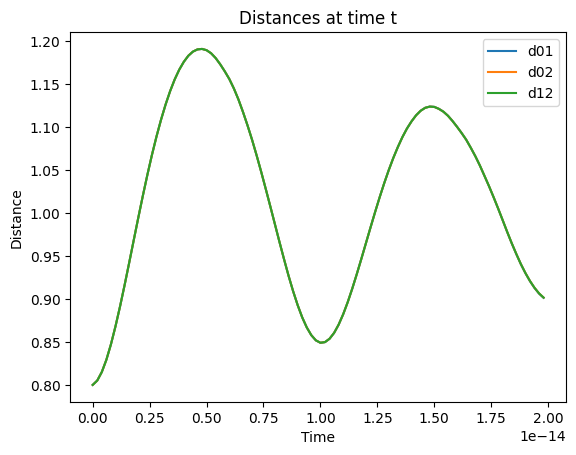

In [6]:
np_distance01 = np.array(distance01)
np_distance02 = np.array(distance02)
np_distance12 = np.array(distance12)

plt.plot(times,np_distance01[:-1],label = 'd01')
plt.plot(times,np_distance02[:-1],label = 'd02')
plt.plot(times,np_distance12[:-1],label = 'd12')
plt.title('Distances at time t')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()